# Feature Importance and Auto Encoders

This notebook will contain the 
1. generation of Principal Components for different bins of a histogram
2. draw the hisogram with the Principal Components
3. Perform feature importance on the PC
4. feed the important feature to an Auto-Encoder
5. generate the ROC-AUC curve 

## 0. PreProcessing, loading and Cleaning data

In [1]:
import numpy as np
from numpy import array
import pandas as pd


import matplotlib.image as mpimg
import matplotlib.cm as cm
from ast import literal_eval
import os

import matplotlib.pyplot as plt
import seaborn as sns

from numpy import array
from scipy.linalg import svd
from scipy import linalg
%matplotlib inline


In [2]:
%%time
#Loading data in pandas dataframes
df_gen_list = []
era = ["B"]
Dir = "/eos/project/c/cmsml4dc/ML_2020/UL2017_Data/"
for j in era:
    a = len(os.listdir(Dir + "DF2017{}_1D_Complete".format(j)))
    
    for i in range(1,a+1,1):
        path = "/eos/project/c/cmsml4dc/ML_2020/UL2017_Data/DF2017{}_1D_Complete/ZeroBias_2017{}_DataFrame_1D_{}.csv".format(j,j,i)
        df_gen_list.append(pd.read_csv(path))
    print("era_{}_finished".format(j))
#print(df_list)

era_B_finished
CPU times: user 18.4 s, sys: 1.9 s, total: 20.3 s
Wall time: 20.5 s


In [3]:
df_gen = pd.concat(df_gen_list)

In [5]:
df_gen.head()

fromrun  fromlumi          hname  fromrun.1  fromlumi.1  metype  \
0   299178       105     goodvtxNbr     299178         105       3   
1   299178       105  adc_PXLayer_1     299178         105       3   
2   299178       105  adc_PXLayer_2     299178         105       3   
3   299178       105  adc_PXLayer_3     299178         105       3   
4   299178       105  adc_PXLayer_4     299178         105       3   

         hname.1                                              histo   entries  \
0     goodvtxNbr  [0, 566, 0, 0, 0, 0, 0, 0, 1, 0, 5, 3, 10, 19,...      2616   
1  adc_PXLayer_1  [0, 32351, 8706, 19347, 55890, 92781, 200276, ...  23438239   
2  adc_PXLayer_2  [0, 4217, 12516, 24066, 139964, 340003, 923405...  15075533   
3  adc_PXLayer_3  [0, 628, 11522, 37935, 209974, 489185, 1064778...  11736105   
4  adc_PXLayer_4  [0, 812, 2972, 13850, 98961, 306140, 803094, 6...   9609418   

    Xmax  Xmin  Xbins  Ymax  Ymin  Ybins  
0   79.5  -0.5     80     1     0      1  
1  255.5  -0.5     32     1     0      1  
2  255.5  -0.5     32     1     0      1  
3  255.5  -0.5     32     1     0      1  
4  255.5  -0.5     32     1     0      1

In [5]:
df_gen_layer1= df_gen[df_gen["hname"] == "chargeInner_PXLayer_1"]

df_gen_layer3= df_gen[df_gen["hname"] == "chargeInner_PXLayer_3"]
df_gen_layer4= df_gen[df_gen["hname"] == "chargeInner_PXLayer_4"]

# Layer 1

In [182]:
%%time
#pre-processing and cleaning
df_gen_layer1.set_index(['fromrun','fromlumi'], inplace=True, drop=False)
df_gen_layer1['histo']=df_gen_layer1['histo'].apply(literal_eval)
df_gen_layer1.sort_index(inplace=True)
#df_charge['labels']=0
df_gen_layer1 = df_gen_layer1.loc[df_gen_layer1["entries"] != 0]
arr_g1 = df_gen_layer1["histo"].values.tolist()
arr_g1 = np.asarray(arr_g1)
arr_g1.shape

/usr/local/bin/start_ipykernel.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


CPU times: user 8.41 s, sys: 614 ms, total: 9.02 s
Wall time: 9.01 s


/usr/local/bin/start_ipykernel.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


/usr/local/bin/start_ipykernel.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/bin/start_ipykernel.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


CPU times: user 11.4 s, sys: 352 ms, total: 11.8 s
Wall time: 11.8 s


In [235]:
arr_g1.shape

(27208, 100)

In [184]:
%%time
#removing overflow and underflow bins
arr_g1 = np.delete(arr_g1, np.s_[0::101],1)
Sum_gen1 = np.sum(arr_g1, axis = 1)
#arr_g1 = arr_g1/np.vstack(Sum_gen1)
#arr_g2 = np.delete(arr_g2, np.s_[0::101],1)
#arr_g3 = np.delete(arr_g3, np.s_[0::101],1)
#arr_g4 = np.delete(arr_g4, np.s_[0::101],1)
# how np.s_ works
#first argument is starting index and last argument is the last argument-1 index, and 1 is the axis for columns

CPU times: user 32.3 ms, sys: 5.95 ms, total: 38.2 ms
Wall time: 35.6 ms


## 1. Generation of PC for different bins of the histograms using Singular Value Decomposition for Layer 1

In [185]:
#genData
from sklearn.decomposition import TruncatedSVD
# define array
G1 = arr_g1
#print(A)
# svd
svd = TruncatedSVD(n_components=50)
svd.fit(G1)
result_gen1 = svd.transform(G1)
print(type(result_gen1))

<class 'numpy.ndarray'>


In [186]:
df_gen_layer1.shape

(27208, 15)

In [187]:
df_gen_layer1["PC"] = result_gen1.tolist()

In [188]:
x.shape, result_gen1[0:1,:].shape, type(x), type(result_gen1[0:1,:])


((50,), (1, 50), numpy.ndarray, numpy.ndarray)

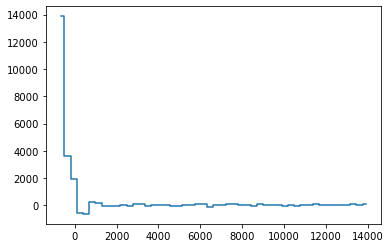

In [189]:
Xmax = result_gen1[1:2,:].max()
Xmin = result_gen1[1:2,:].min()
Xbins = 50
x = np.linspace(Xmin,Xmax,Xbins)
plt.step(x, result_gen1[1:2,:][0],where='mid',)

In [190]:
df_gen_layer1.head()

fromrun  fromlumi                  hname  fromrun.1  \
fromrun fromlumi                                                        
297047  1          297047         1  chargeInner_PXLayer_1     297047   
        2          297047         2  chargeInner_PXLayer_1     297047   
        3          297047         3  chargeInner_PXLayer_1     297047   
        4          297047         4  chargeInner_PXLayer_1     297047   
        5          297047         5  chargeInner_PXLayer_1     297047   

                  fromlumi.1  metype                hname.1  \
fromrun fromlumi                                              
297047  1                  1       3  chargeInner_PXLayer_1   
        2                  2       3  chargeInner_PXLayer_1   
        3                  3       3  chargeInner_PXLayer_1   
        4                  4       3  chargeInner_PXLayer_1   
        5                  5       3  chargeInner_PXLayer_1   

                                                              histo  entries  \
fromrun fromlumi                                                               
297047  1         [0, 39, 198, 378, 571, 784, 1068, 1295, 1465, ...    96516   
        2         [0, 44, 187, 394, 635, 785, 1100, 1309, 1528, ...    98219   
        3         [0, 51, 185, 378, 592, 907, 1157, 1460, 1598, ...   105896   
        4         [0, 35, 192, 338, 596, 909, 1201, 1512, 1759, ...   119261   
        5         [0, 37, 192, 369, 674, 932, 1245, 1520, 1946, ...   125286   

                     Xmax  Xmin  Xbins  Ymax  Ymin  Ybins  \
fromrun fromlumi                                            
297047  1         80000.0   0.0    100     1     0      1   
        2         80000.0   0.0    100     1     0      1   
        3         80000.0   0.0    100     1     0      1   
        4         80000.0   0.0    100     1     0      1   
        5         80000.0   0.0    100     1     0      1   

                                                                 PC  
fromrun fromlumi                                                     
297047  1         [13633.450140125433, 3590.100134636334, 1812.0...  
        2         [13883.13137699171, 3646.213538605907, 1893.32...  
        3         [15023.108384125706, 3880.761893173615, 1943.9...  
        4         [16908.189250349576, 4147.2219299149465, 2159....  
        5         [17705.183538827125, 4341.515456335251, 2353.0...

In [191]:
min(min(df_gen_layer1["PC"]))

-2.347720601881414

# Plotting function for both PCA and regular bins

In [192]:
run_list = [i for i in df_gen_layer1.fromrun.unique()]
run_lumi_dict = {}
for run in run_list:
    run_lumi_dict[run] = df_gen_layer1[df_gen_layer1["fromrun"] == run]["fromlumi.1"].values.tolist()

In [193]:
run_lumi_dict

{297047: [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28],
 297048: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 297049: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 297050: [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  1

W0424 20:29:05.764550 139688047490880 legend.py:1282] No handles with labels found to put in legend.
W0424 20:29:05.926567 139688047490880 legend.py:1282] No handles with labels found to put in legend.
W0424 20:29:06.126137 139688047490880 legend.py:1282] No handles with labels found to put in legend.
W0424 20:29:08.175307 139688047490880 legend.py:1282] No handles with labels found to put in legend.
W0424 20:29:09.127792 139688047490880 legend.py:1282] No handles with labels found to put in legend.
W0424 20:29:12.060739 139688047490880 legend.py:1282] No handles with labels found to put in legend.
W0424 20:29:13.214585 139688047490880 legend.py:1282] No handles with labels found to put in legend.
W0424 20:29:14.449731 139688047490880 legend.py:1282] No handles with labels found to put in legend.
W0424 20:29:19.164543 139688047490880 legend.py:1282] No handles with labels found to put in legend.
/usr/local/bin/start_ipykernel.py:42: UserWarning: Creating legend with loc="best" can be s

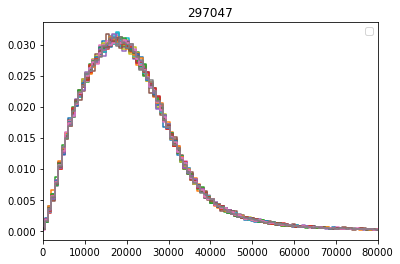

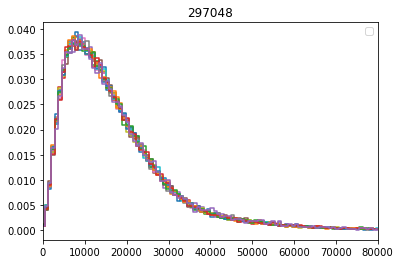

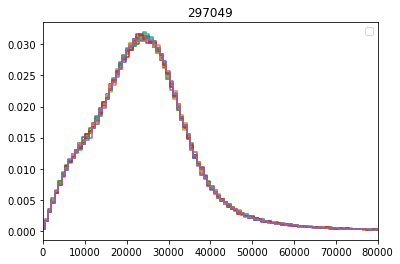

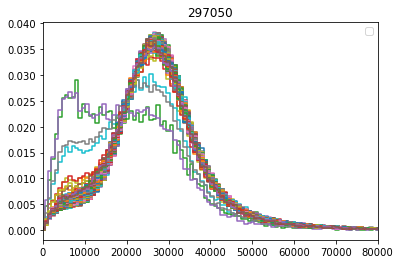

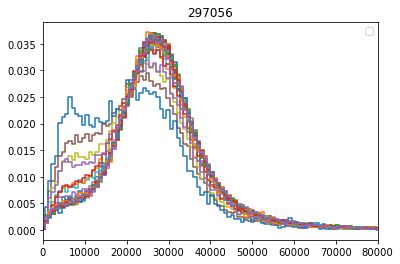

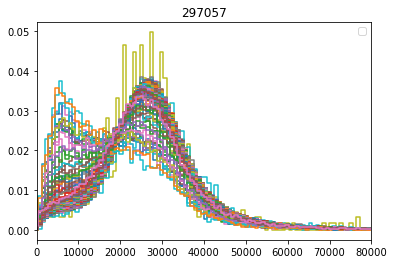

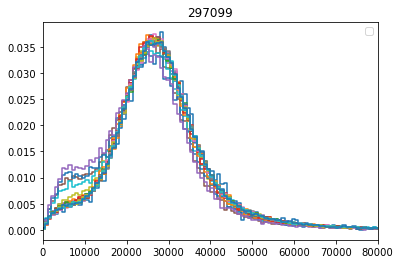

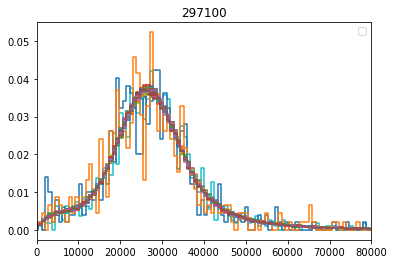

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(

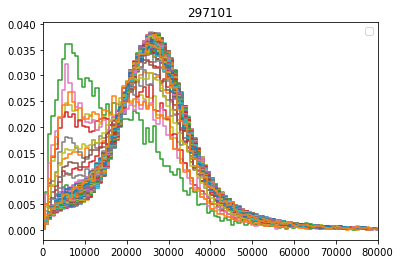

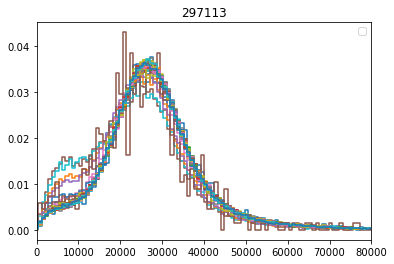

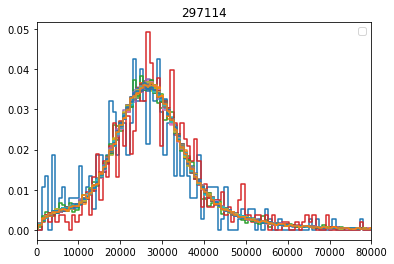

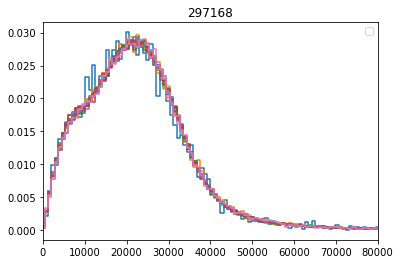

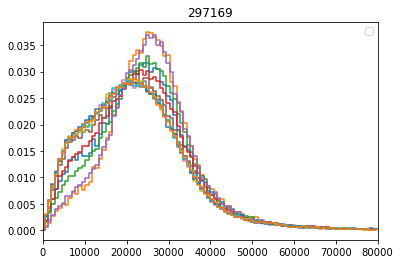

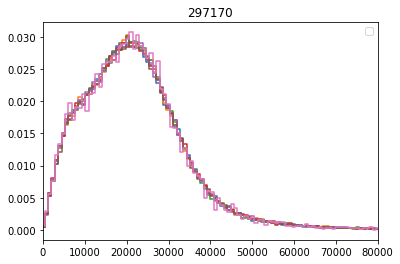

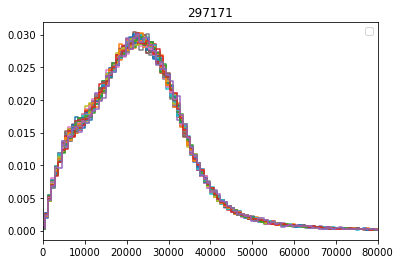

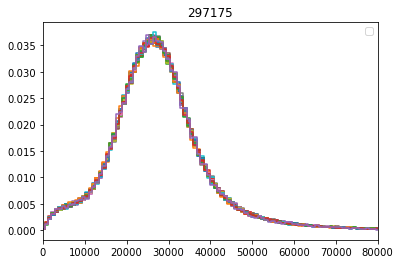

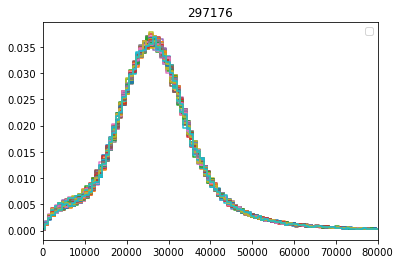

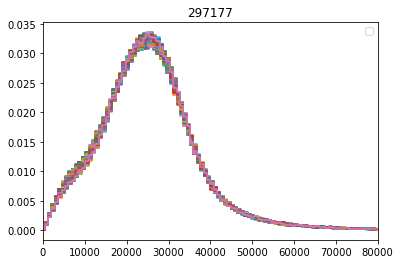

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(

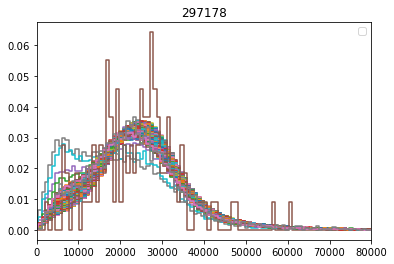

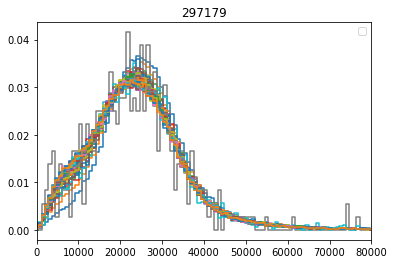

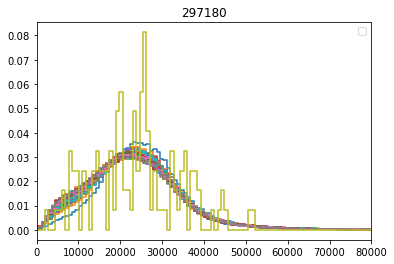

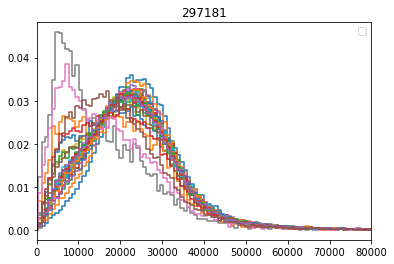

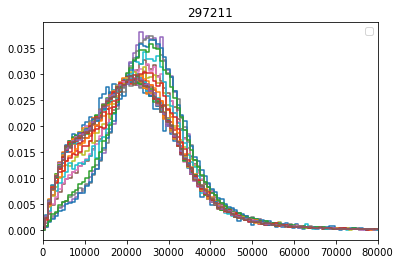

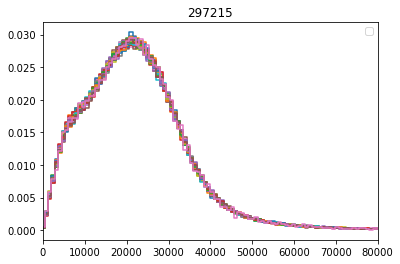

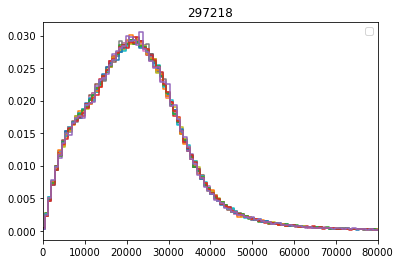

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(

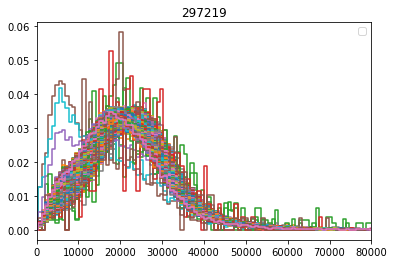

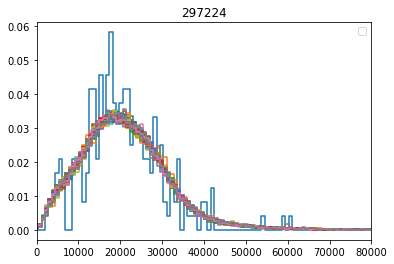

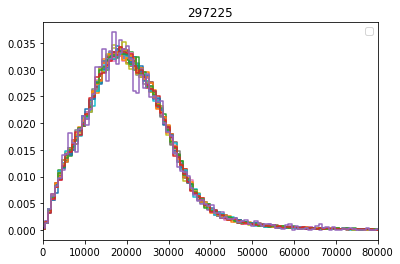

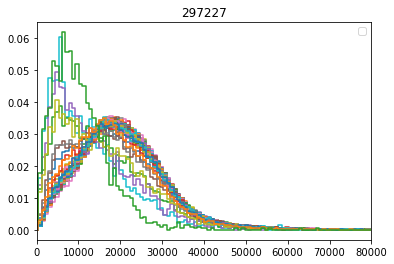

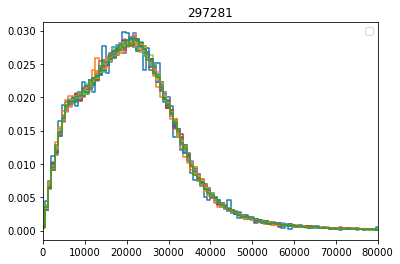

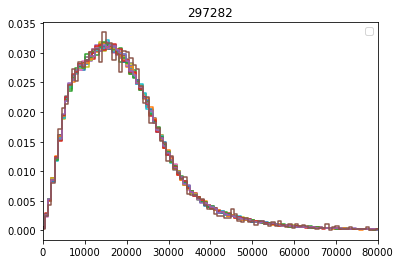

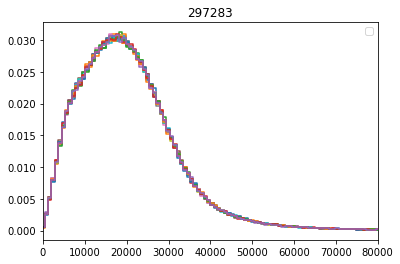

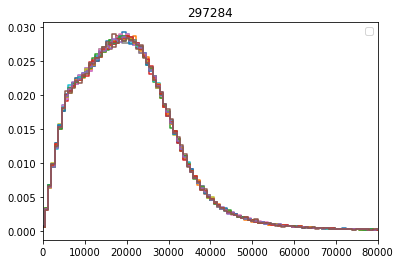

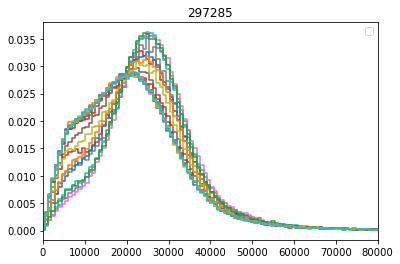

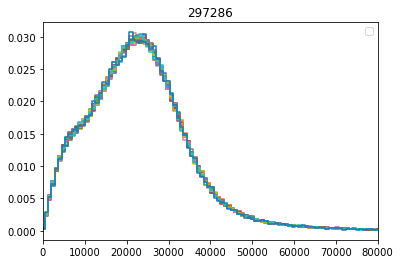

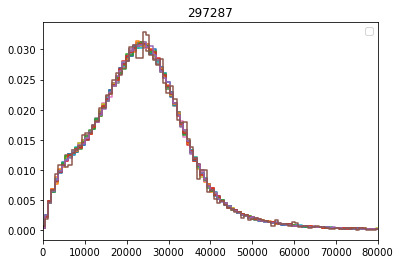

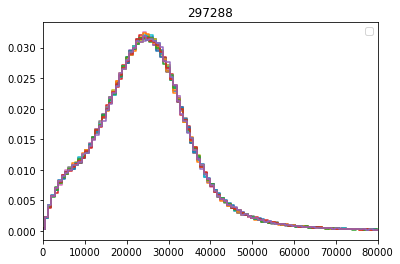

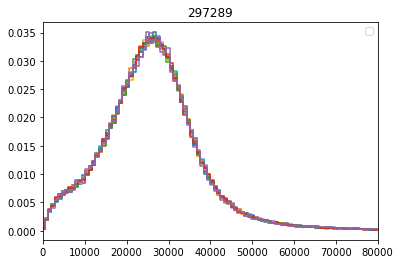

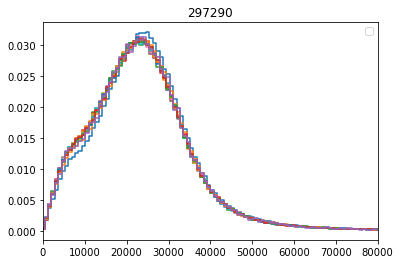

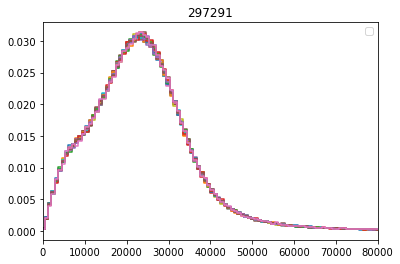

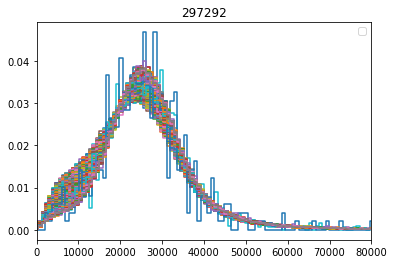

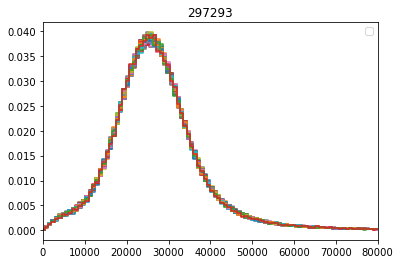

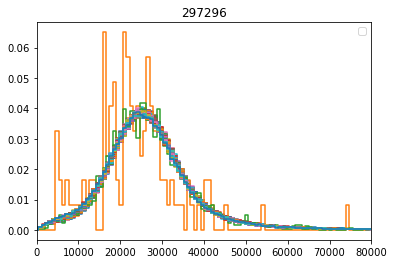

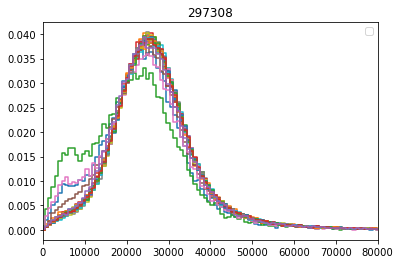

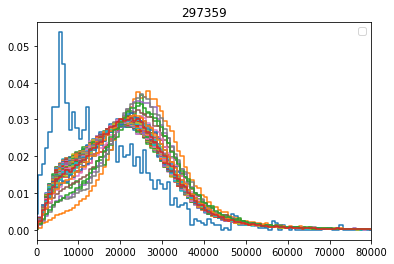

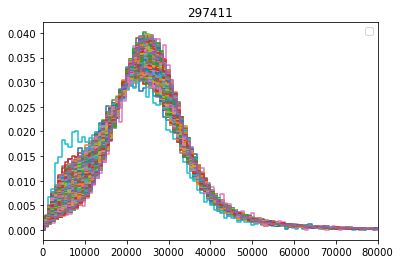

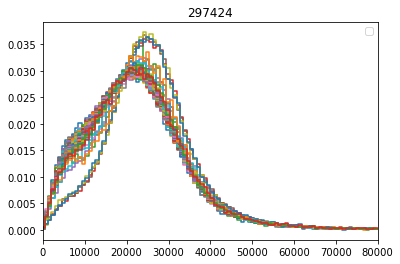

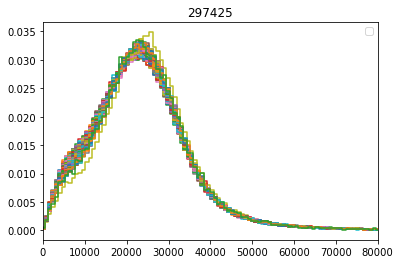

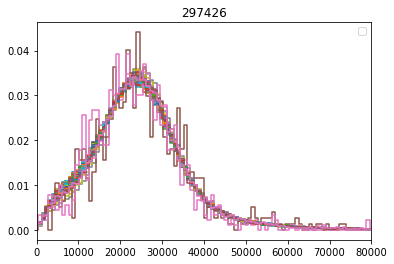

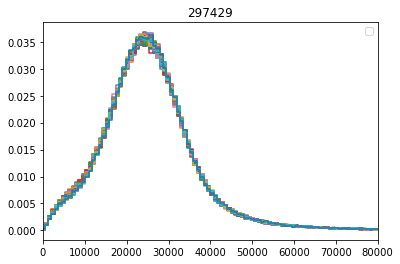

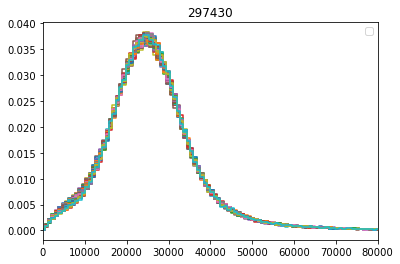

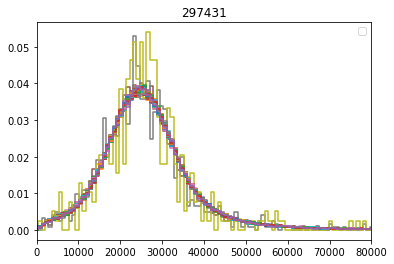

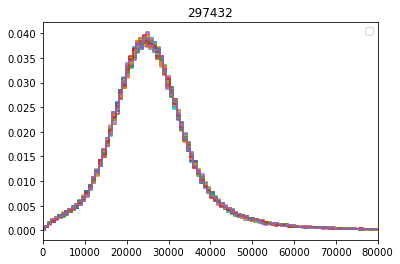

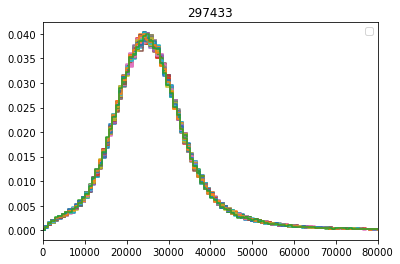

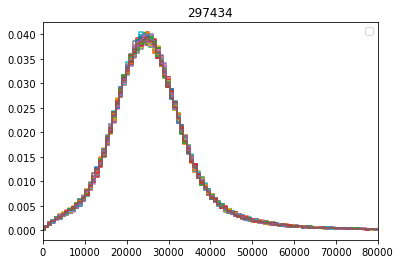

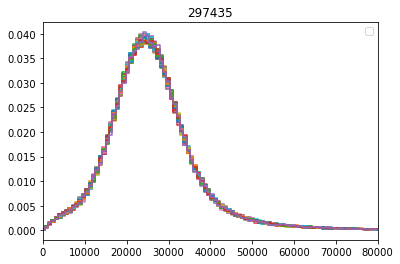

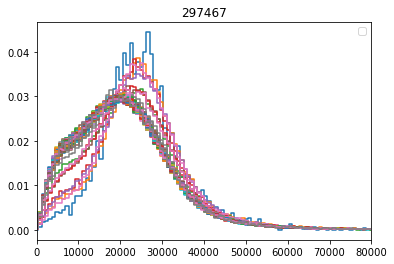

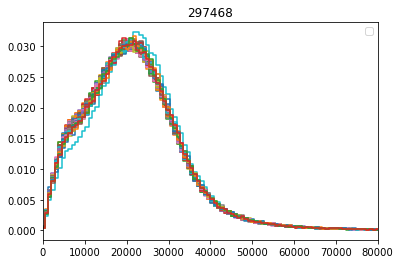

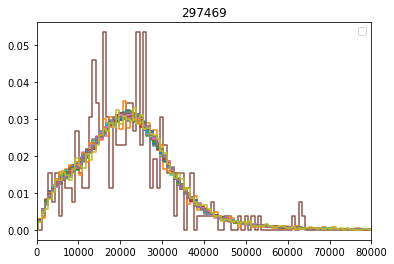

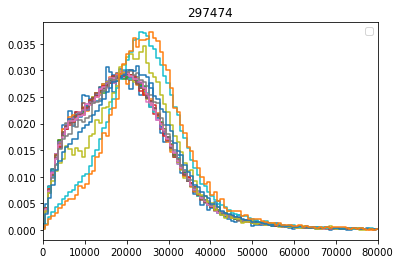

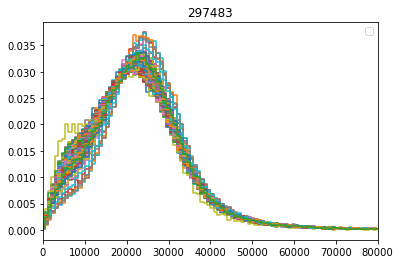

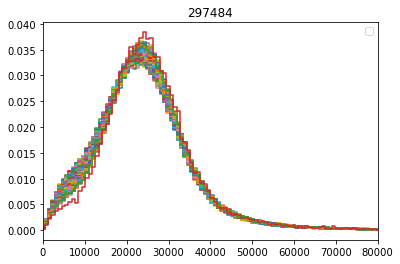

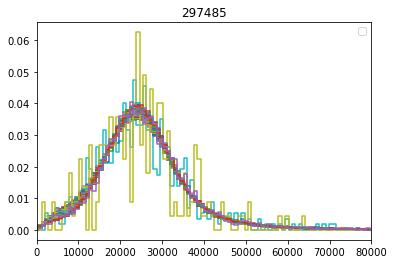

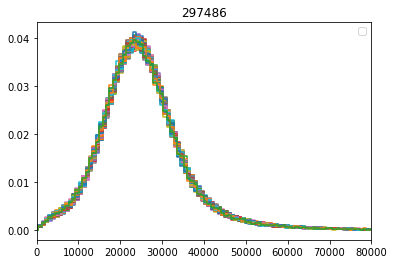

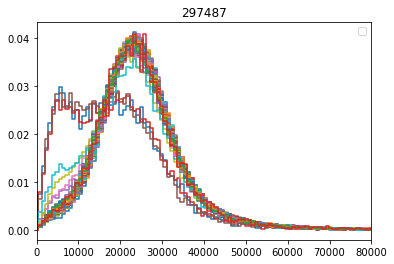

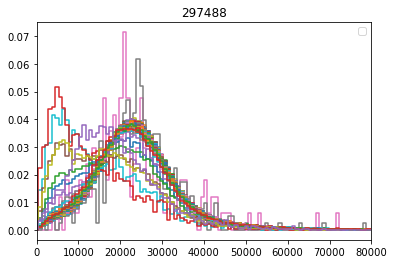

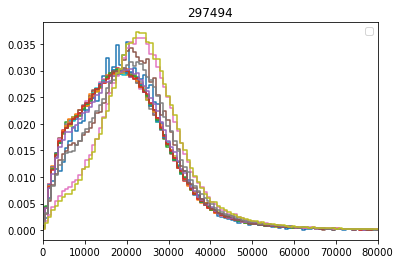

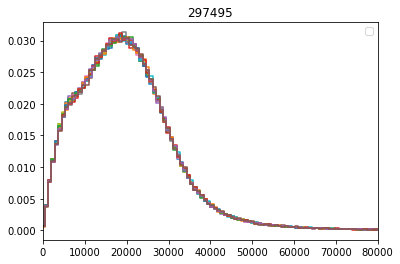

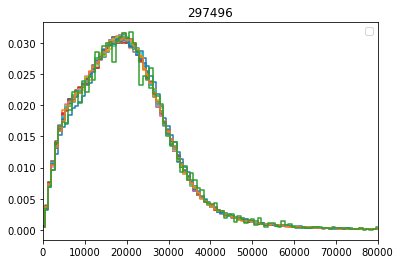

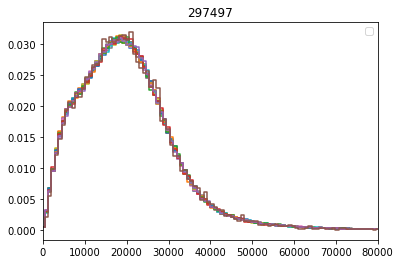

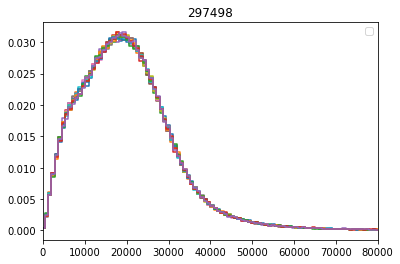

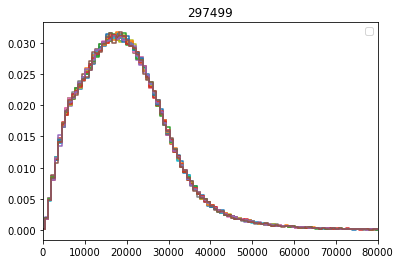

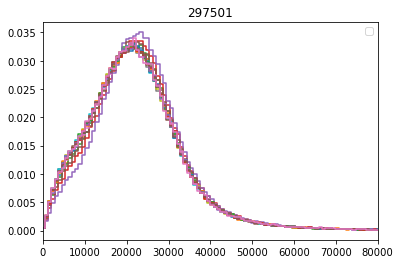

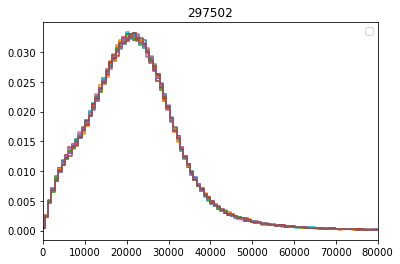

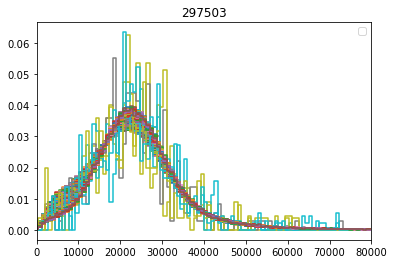

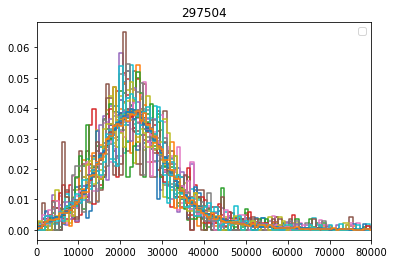

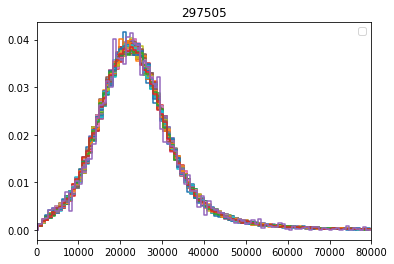

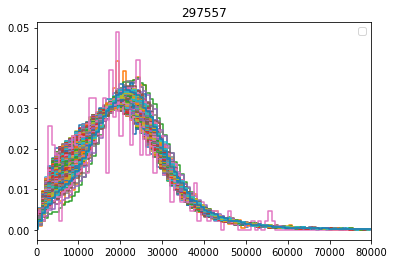

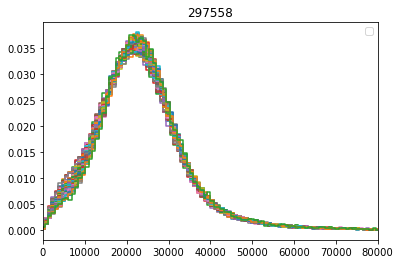

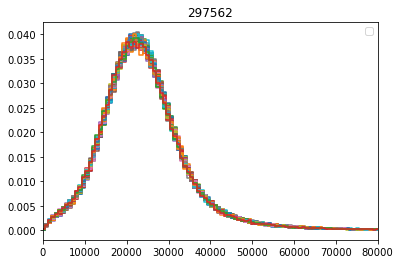

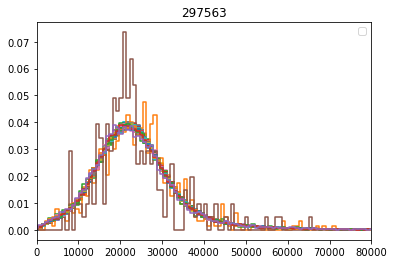

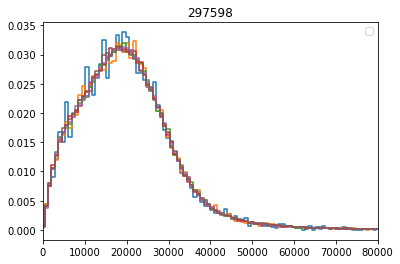

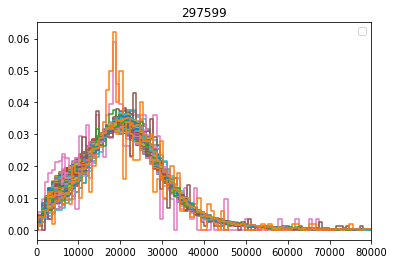

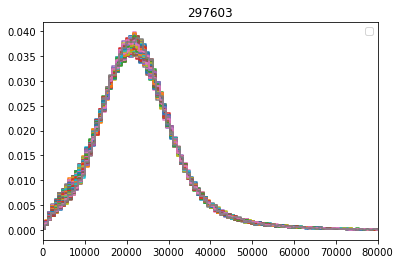

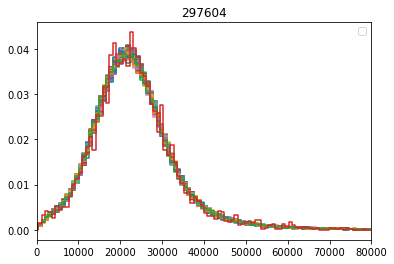

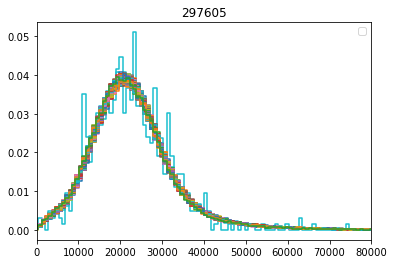

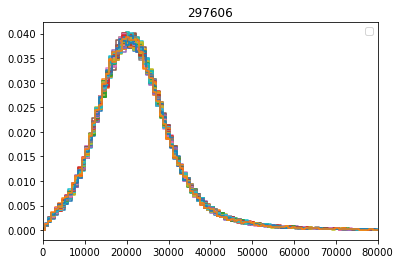

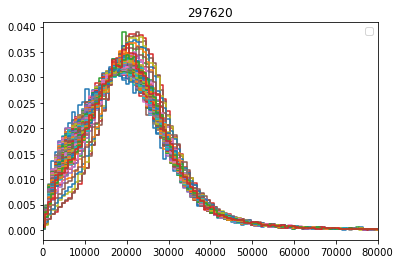

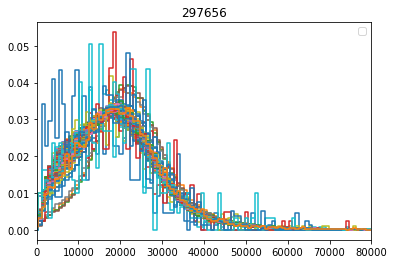

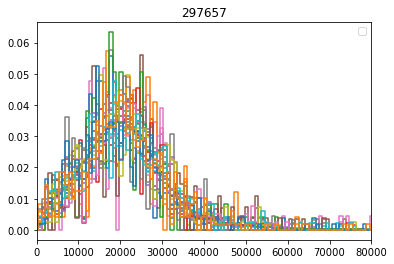

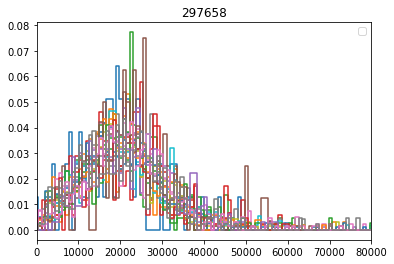

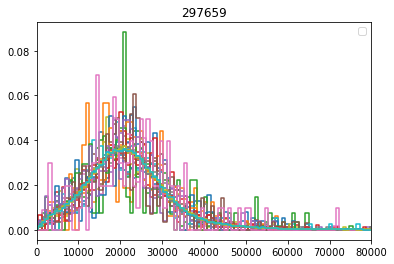

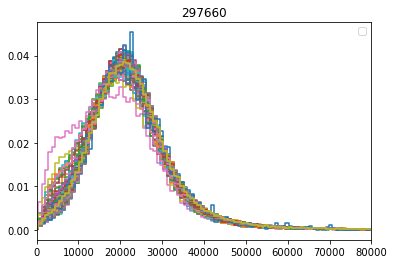

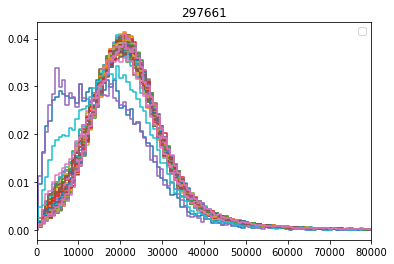

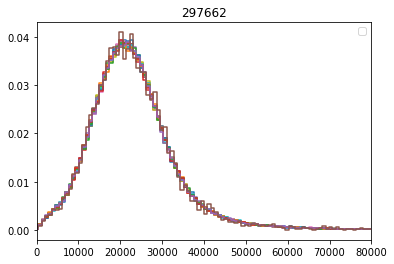

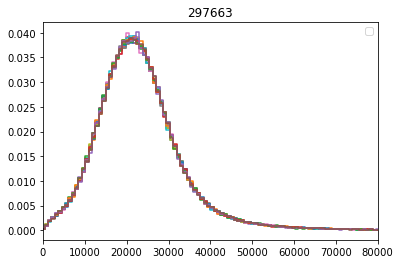

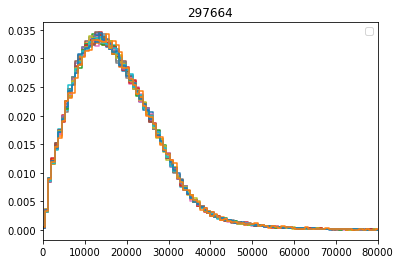

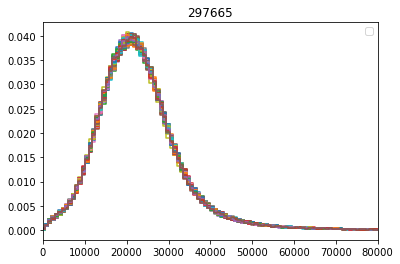

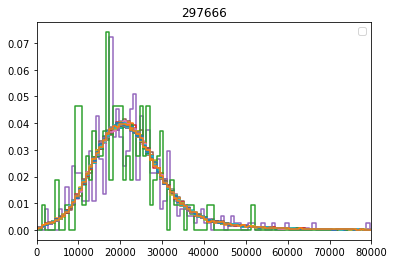

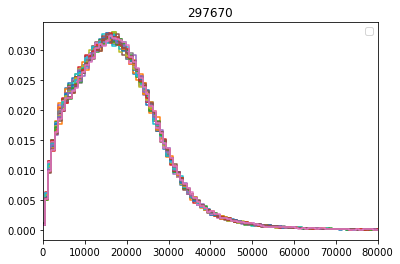

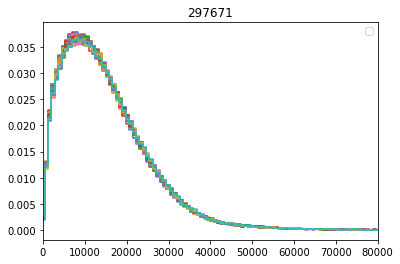

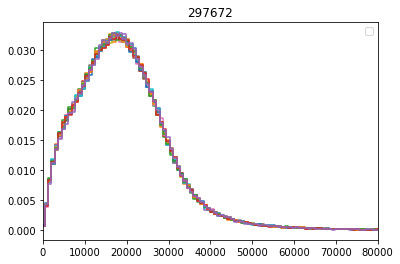

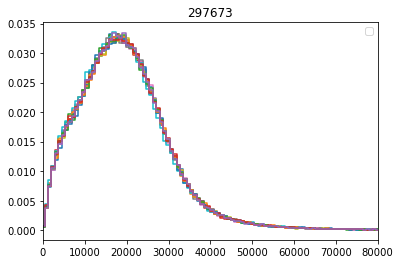

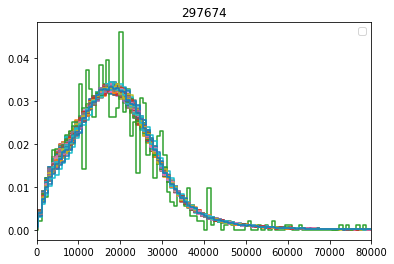

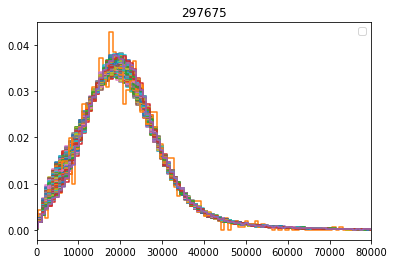

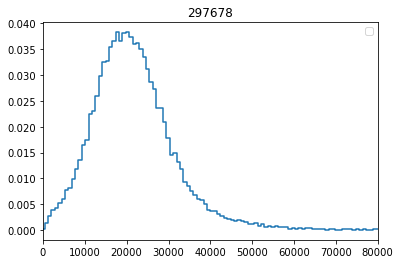

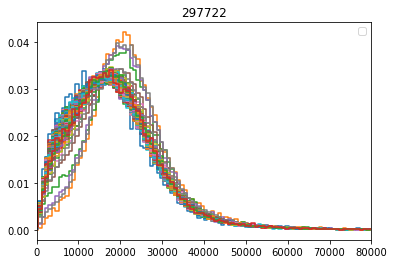

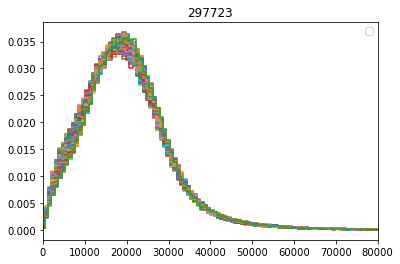

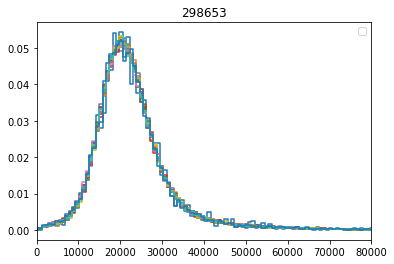

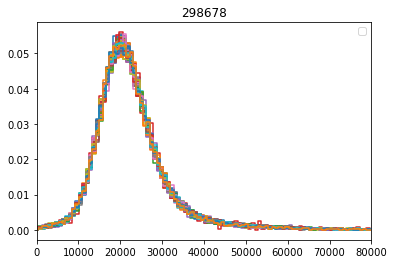

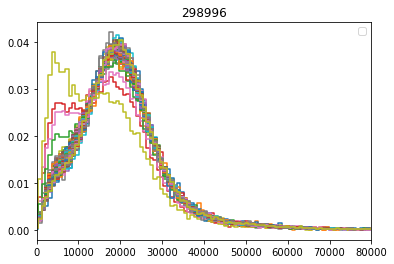

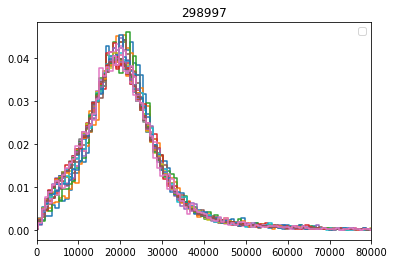

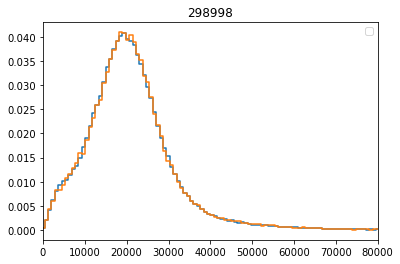

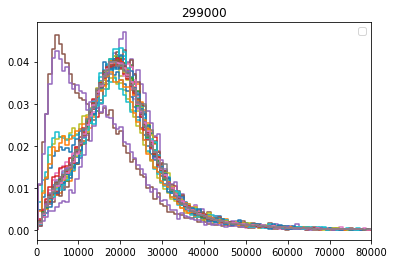

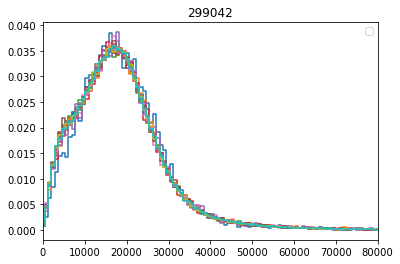

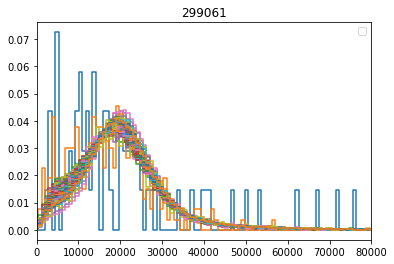

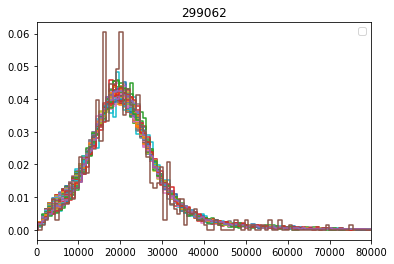

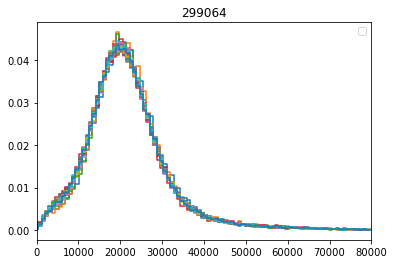

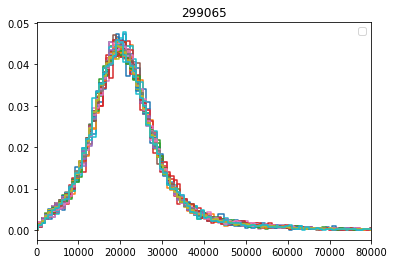

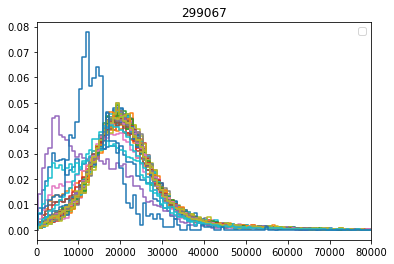

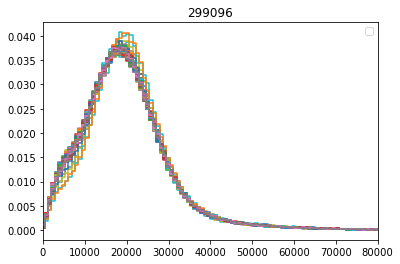

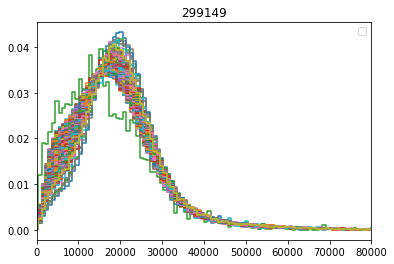

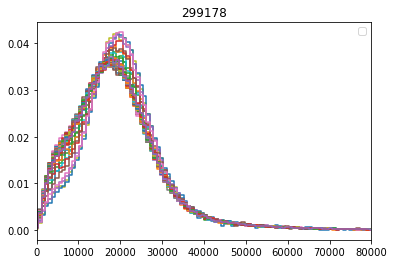

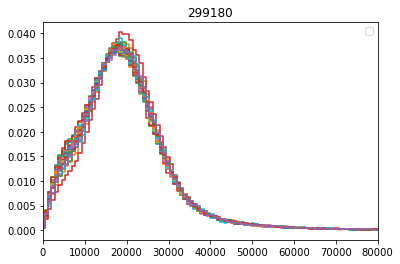

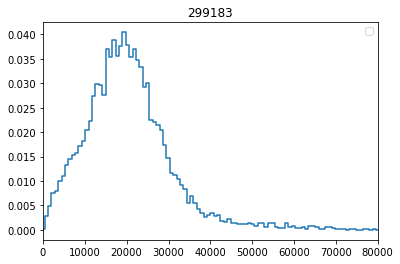

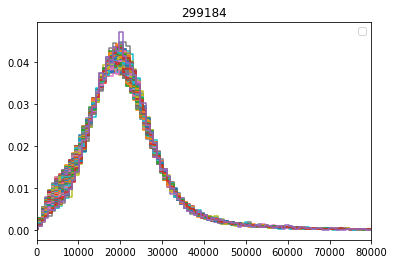

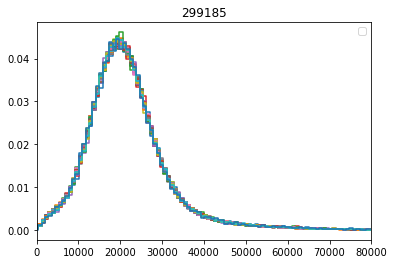

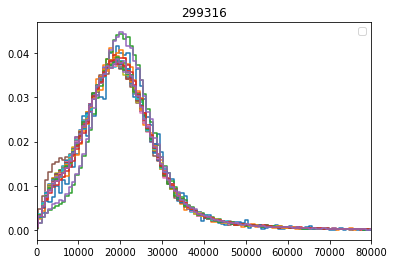

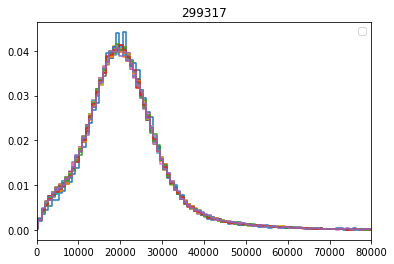

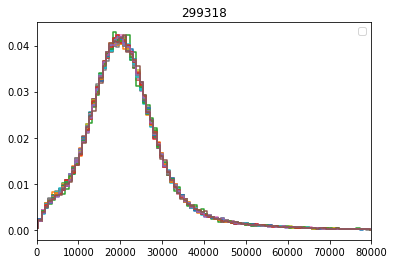

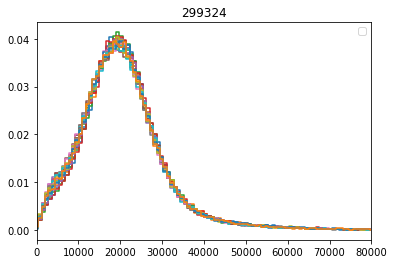

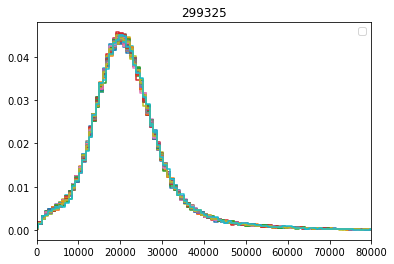

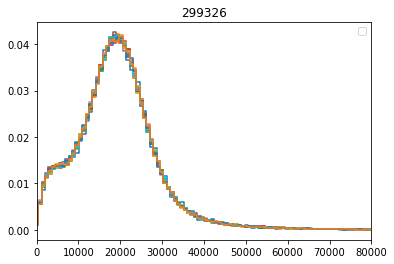

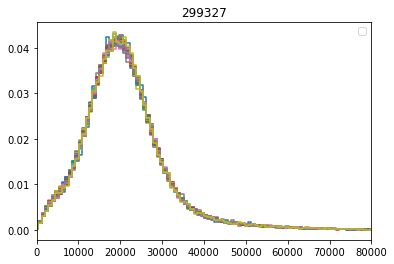

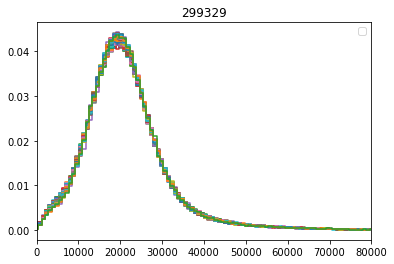

In [211]:
#plot hist
mean_dict = {}
sd_dict = {}
def PlotHist(run,ls_list, ):
    '''
    this function takes the run number and the list of lumiSections
    associated with that run. It further uses that info to extract histogram entries asssociated with each
    LS and plots them on a single histogram
    Overall you'd get a histogram with all lumisection plotted for that particular run
    '''
    
    #declaration for hist
    fig = plt.figure()
    Xmax=80000.0
    Xmin=0.0
    Xbins=100

    hname="chargeInner_PXLayer_1"
    global mean_dict
    global sd_dict
    
    global df_gen_layer1
    for ls in ls_list:
        
        ahisto=df_gen_layer1['histo'][run][ls]
        a = len(ahisto)
        if not(a == Xbins):
            ahisto = ahisto[1:-1]
        factor = sum(ahisto)
        x = np.linspace(Xmin,Xmax,Xbins)
        newList = [float(x) / factor for x in ahisto] # normalized histo list dividing ahisto by number of entries
        
        mean_of_each_LSHisto = np.sum([a*b for a,b in zip(x,ahisto)]) / factor
        mean_dict[ls] = mean_of_each_LSHisto
        plt.xlim(Xmin,Xmax)
        plt.step(x, newList, where='mid',) #normalized histo
        #plt.axvline(mean_of_each_LSHisto-sd_of_each_LSHisto, color='k', linestyle='dashed', linewidth=1)
        plt.title(run)
        #plt.step(x, ahisto, where='mid',) #non normalized histo
    plt.legend()
    #plt.annotate("{}".format(np.describe(x)), xy=(0.5, 0.5), xycoords='axes fraction')
    fig.savefig("/eos/home-r/runiyal/SWAN_projects/ML4DC/data_exploration/NEW_HIST_PLOTS/{}.png".format(run))
    
    #del fig
    
    
#this for loop is for running over all the runs     
for run in run_list:
    PlotHist(run,run_lumi_dict[run])


/usr/local/bin/start_ipykernel.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


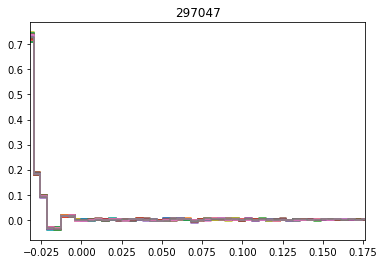

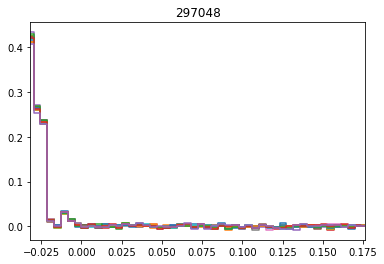

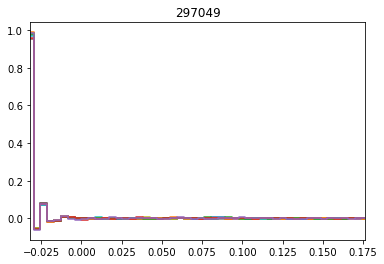

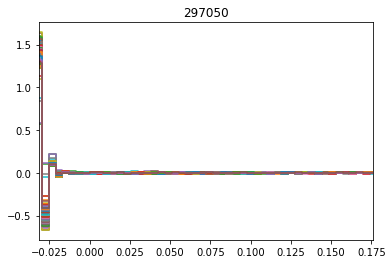

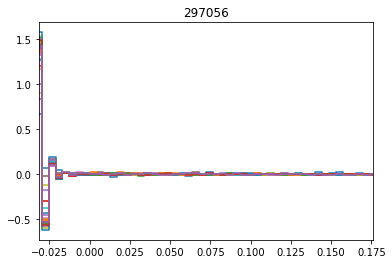

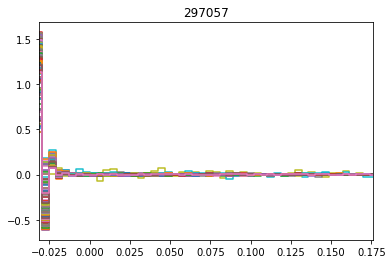

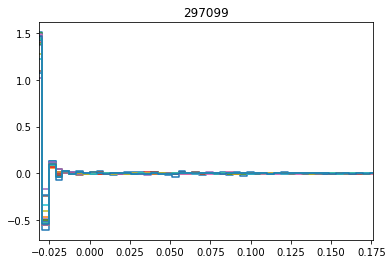

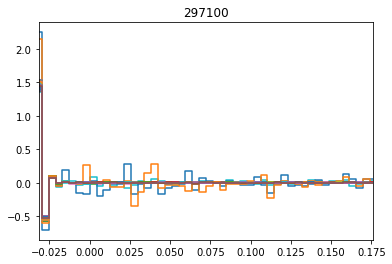

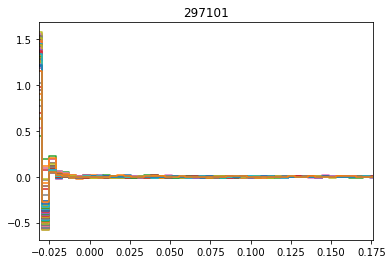

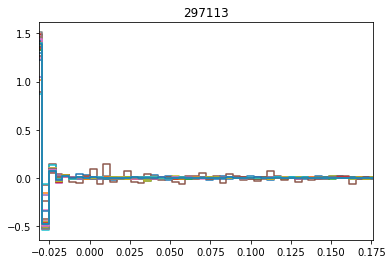

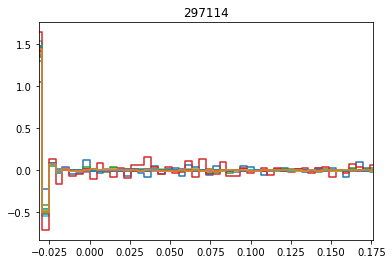

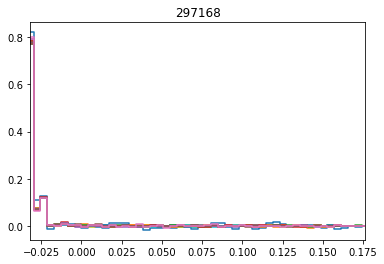

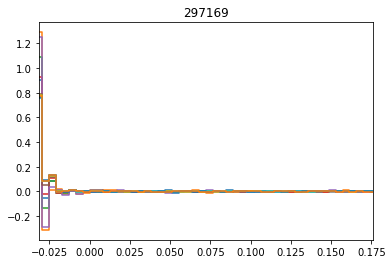

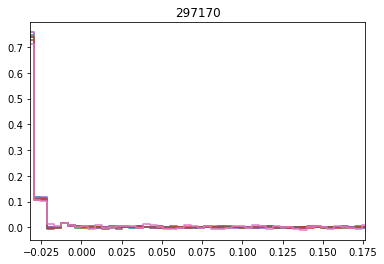

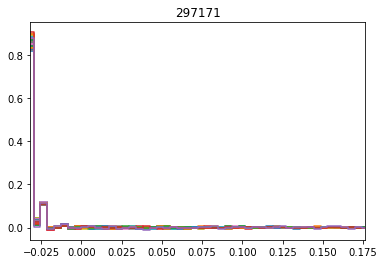

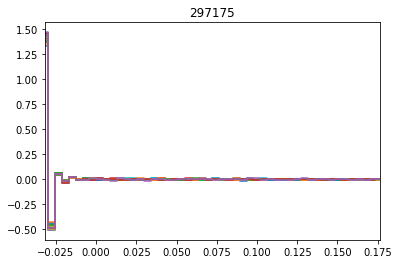

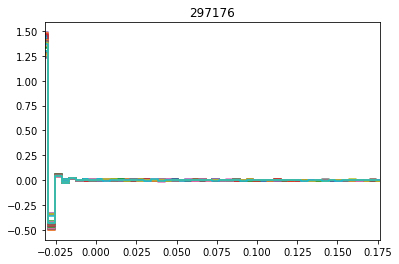

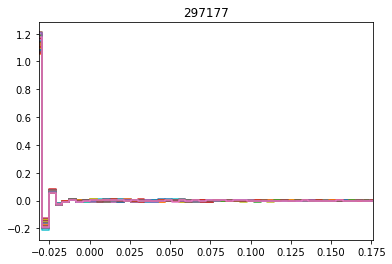

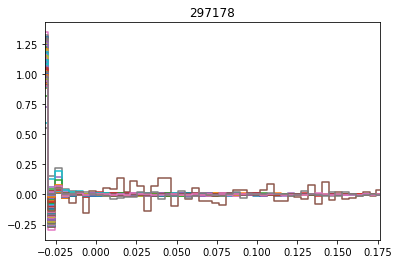

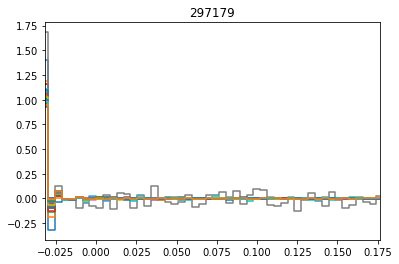

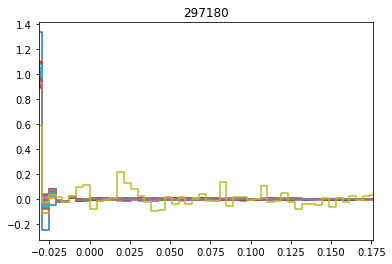

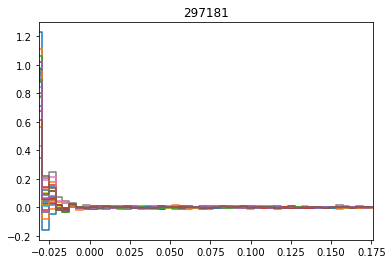

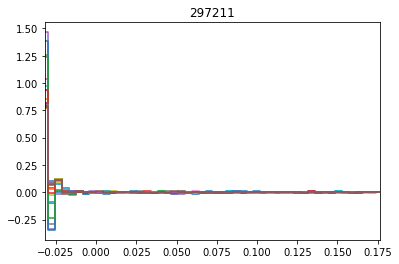

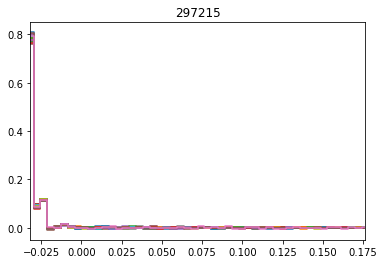

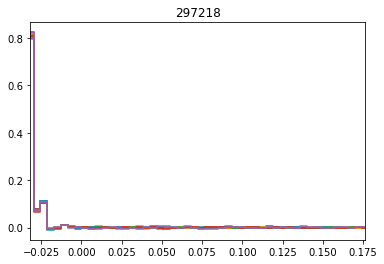

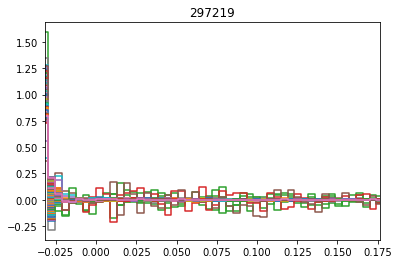

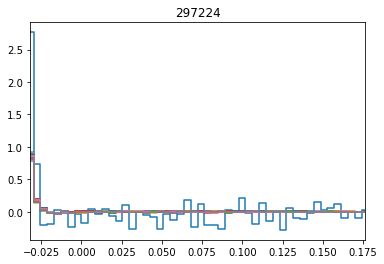

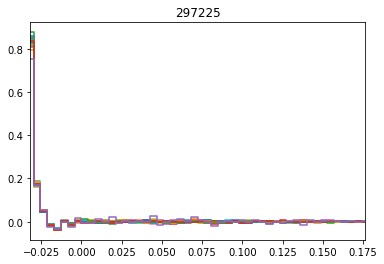

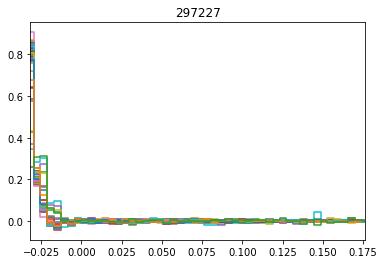

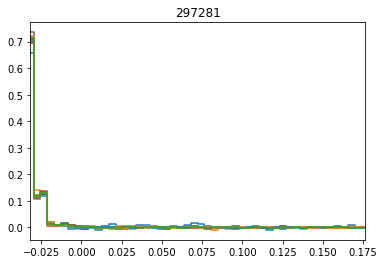

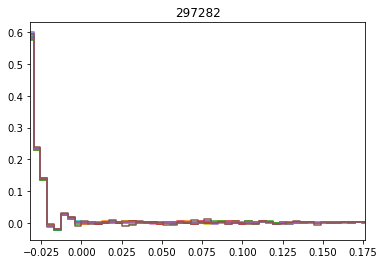

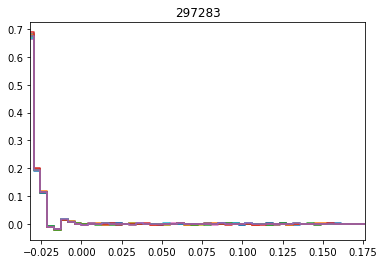

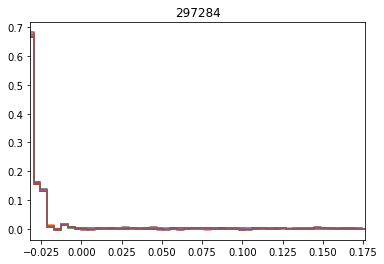

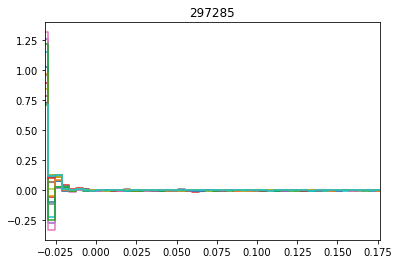

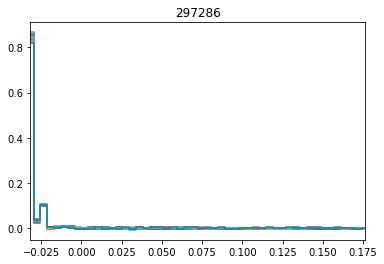

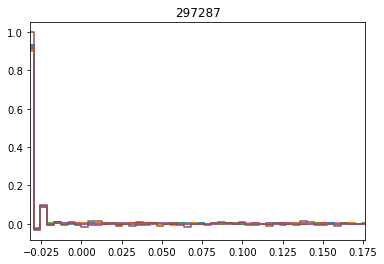

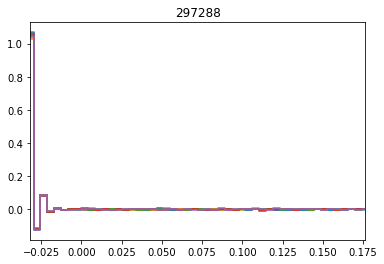

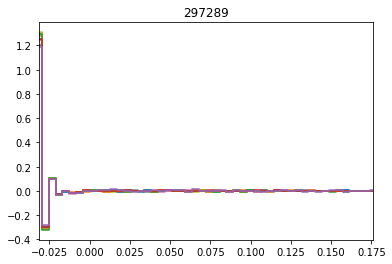

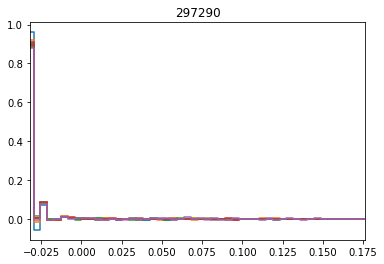

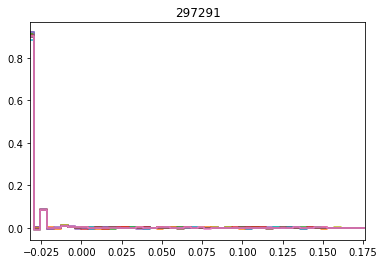

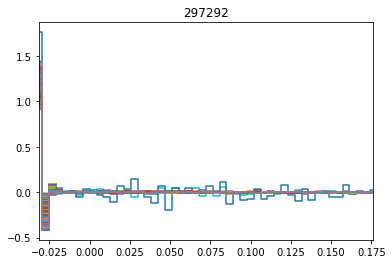

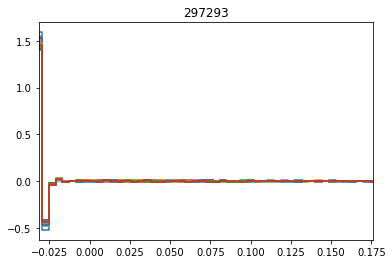

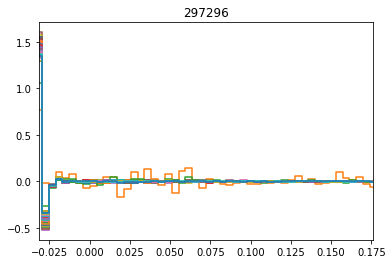

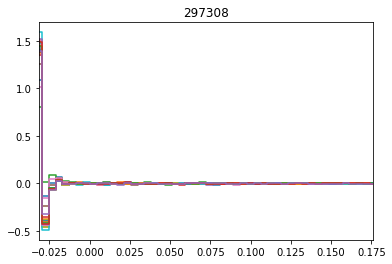

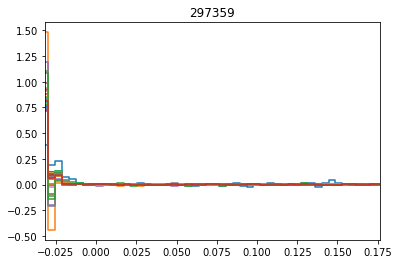

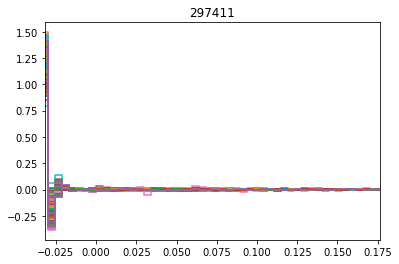

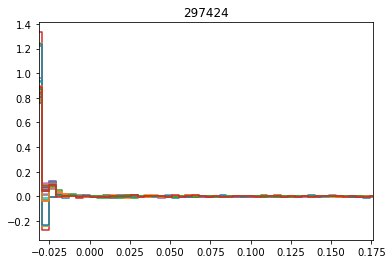

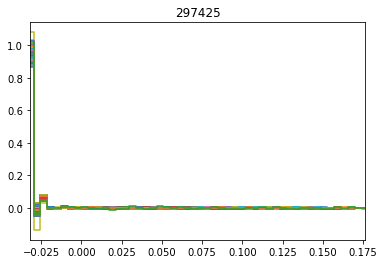

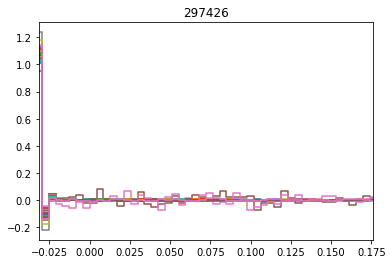

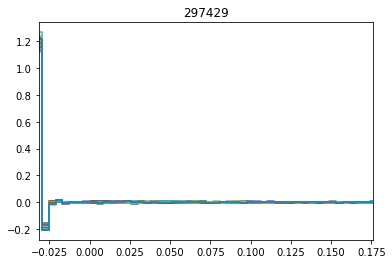

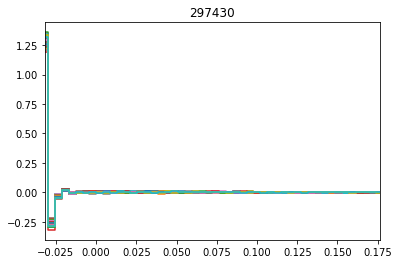

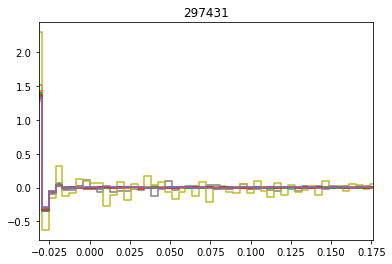

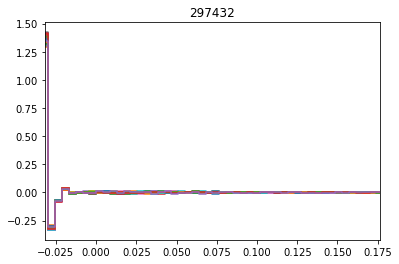

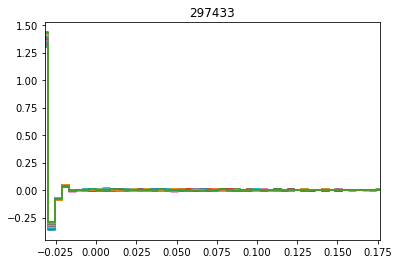

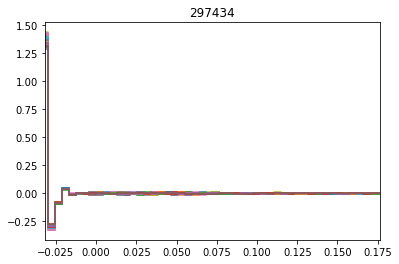

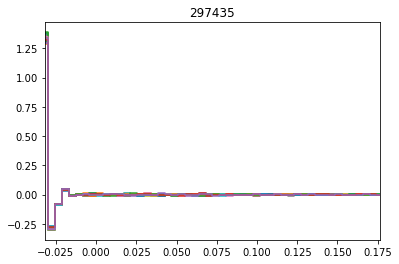

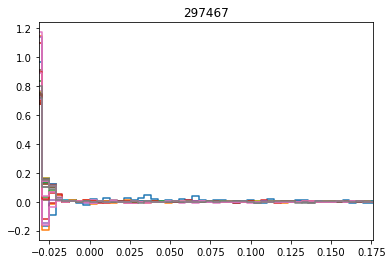

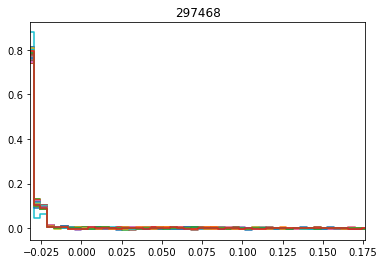

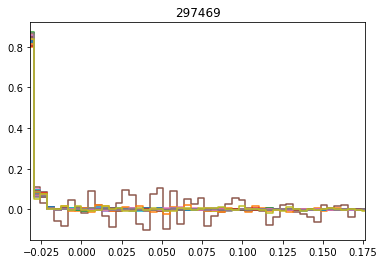

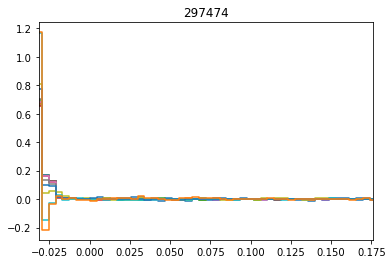

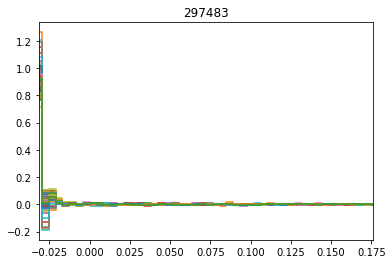

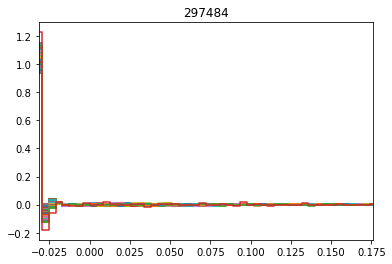

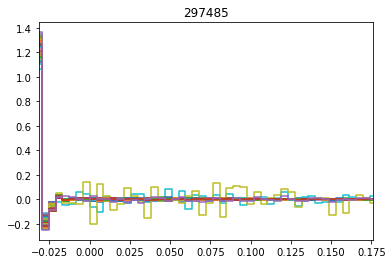

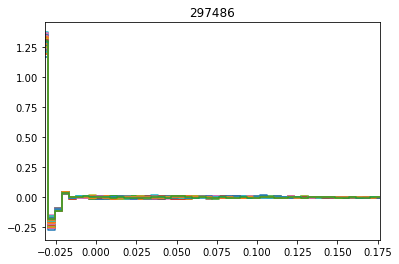

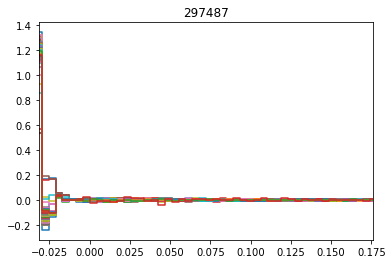

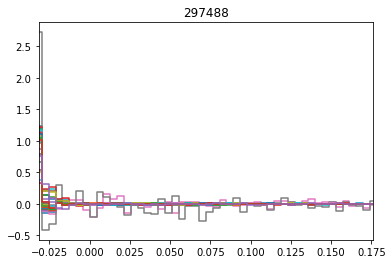

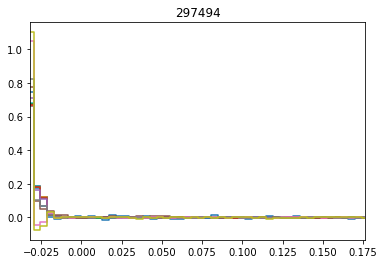

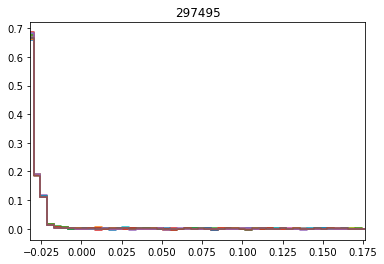

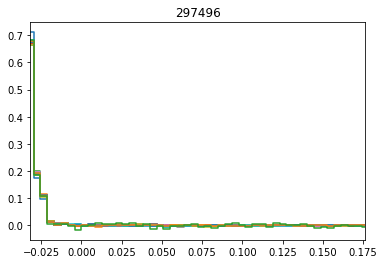

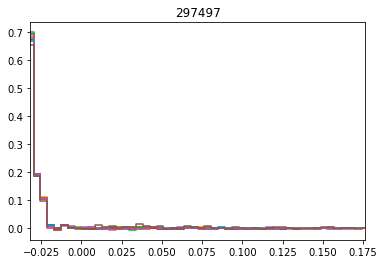

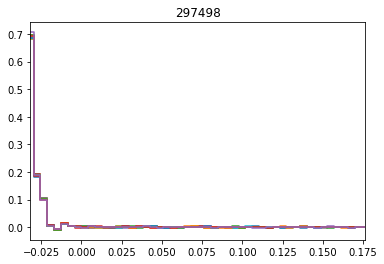

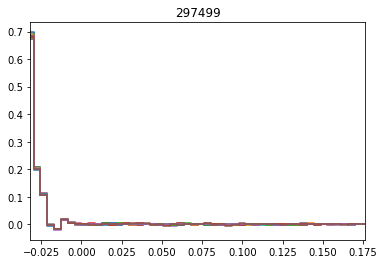

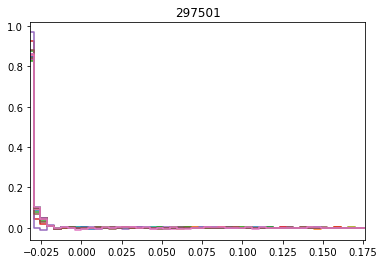

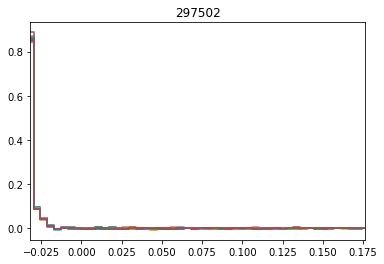

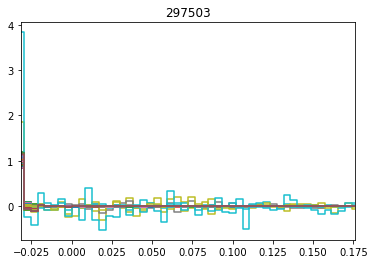

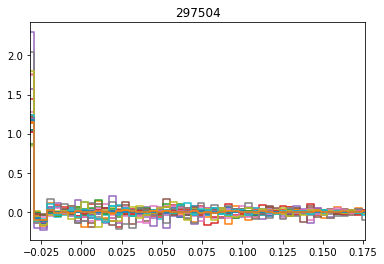

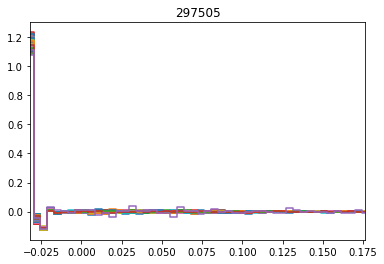

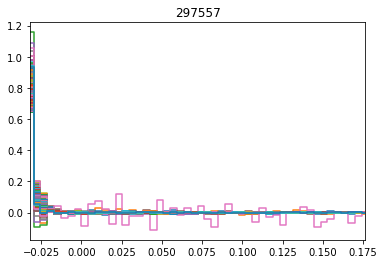

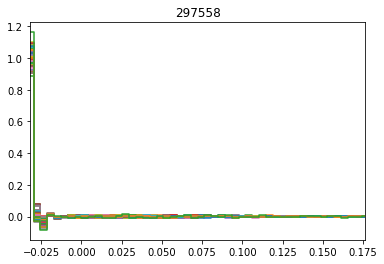

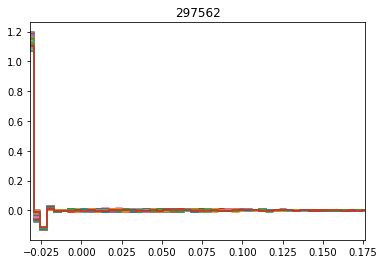

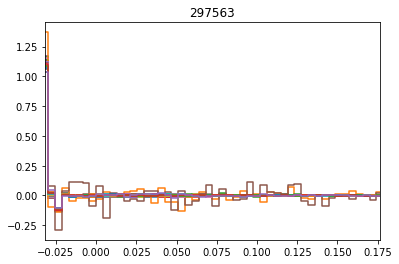

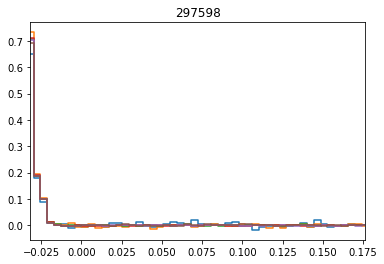

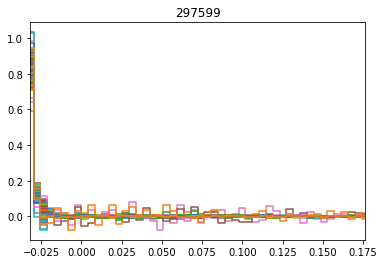

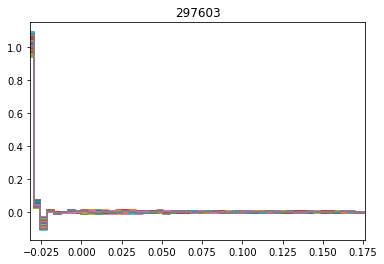

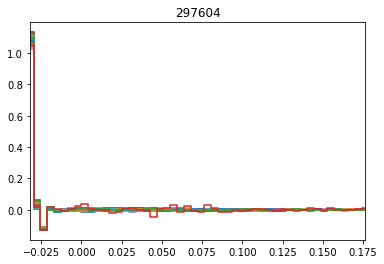

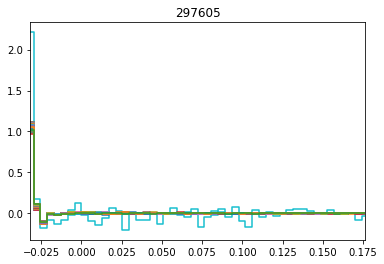

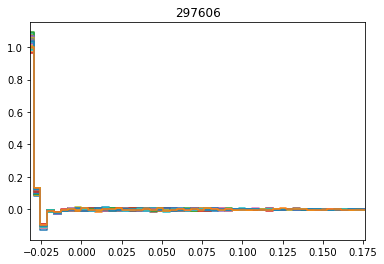

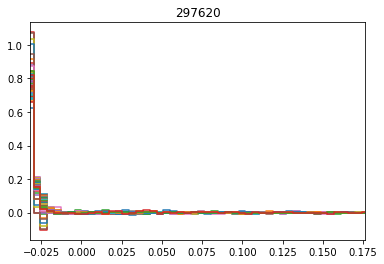

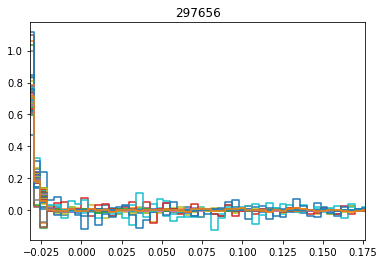

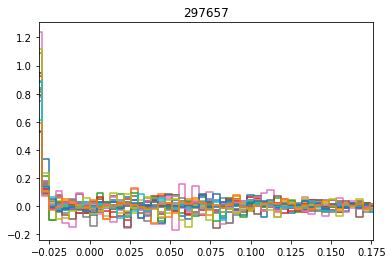

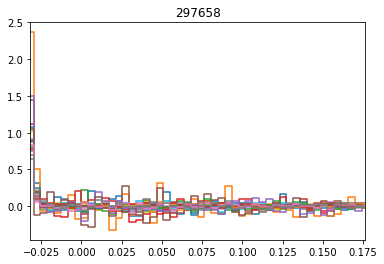

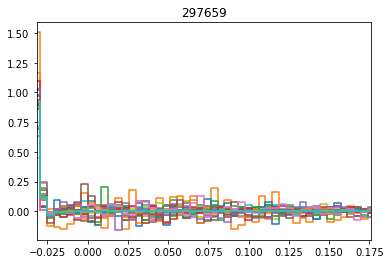

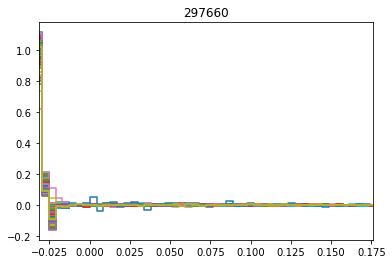

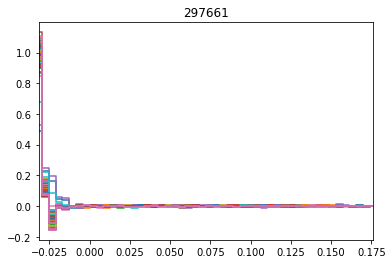

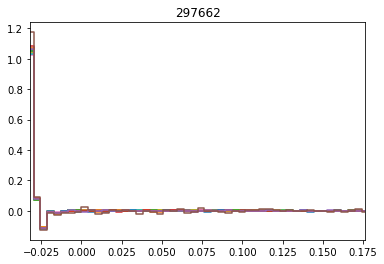

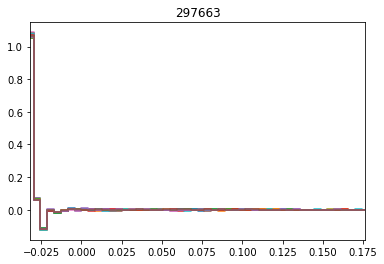

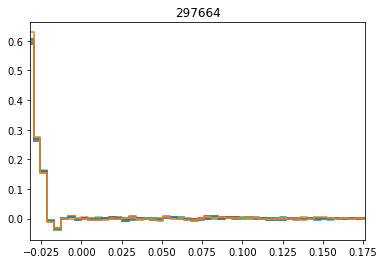

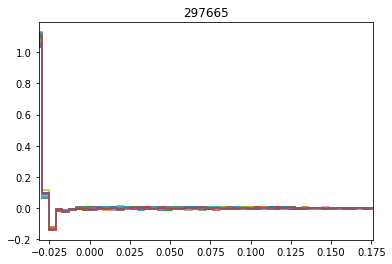

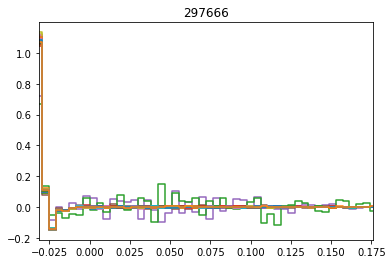

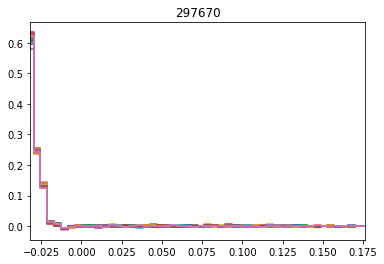

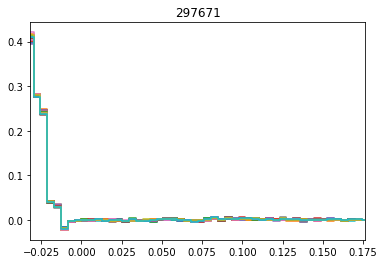

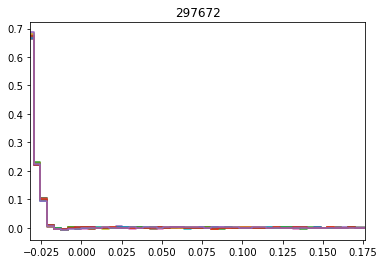

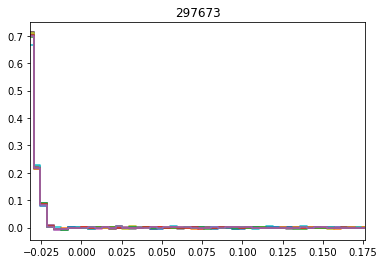

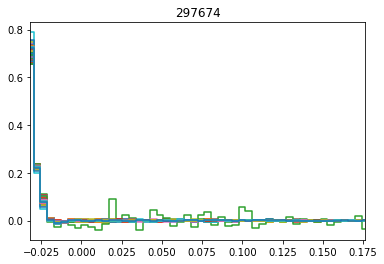

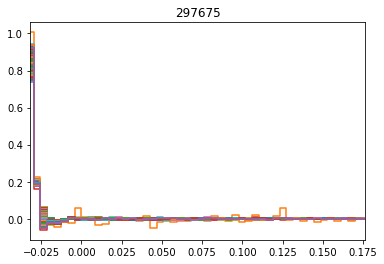

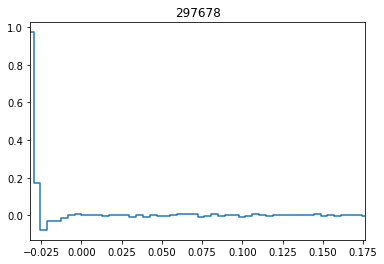

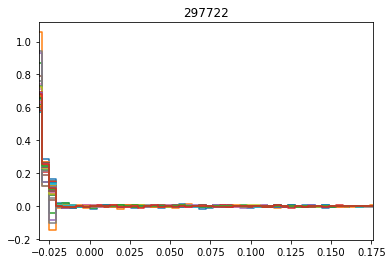

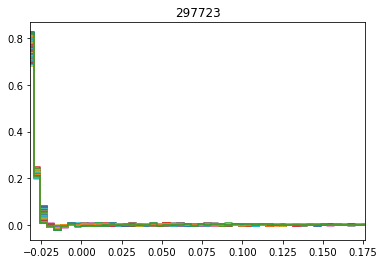

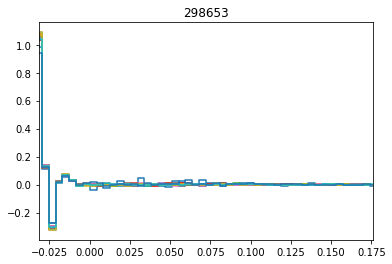

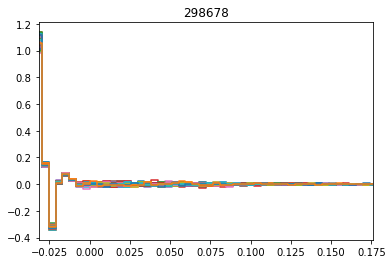

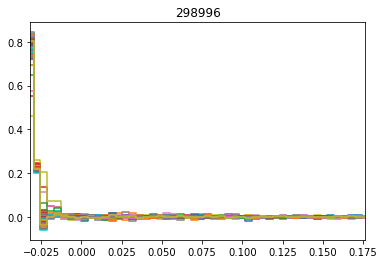

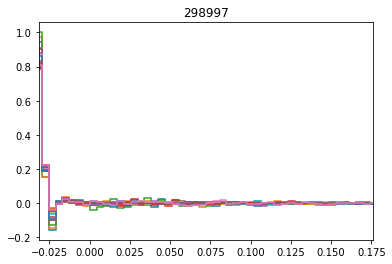

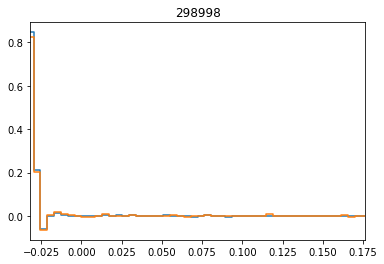

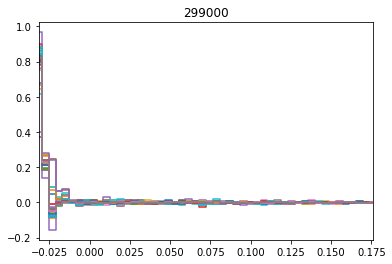

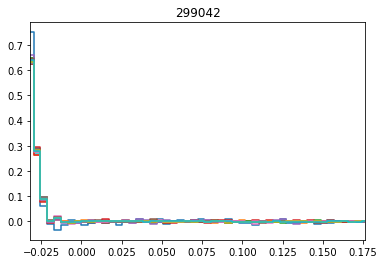

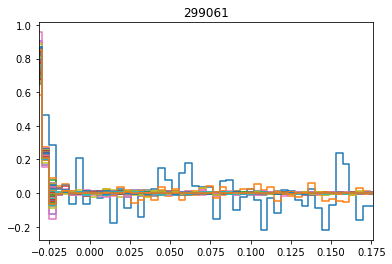

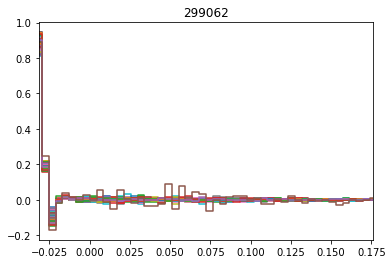

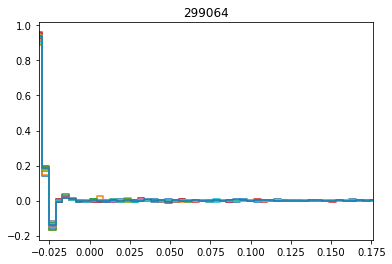

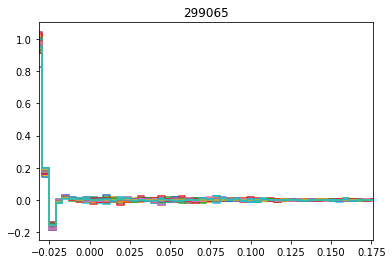

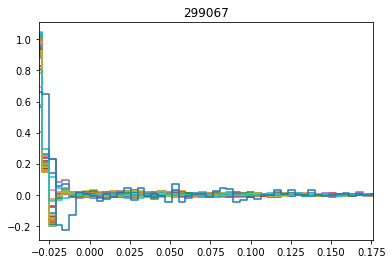

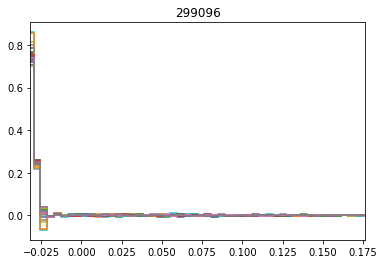

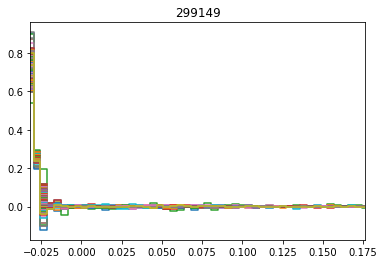

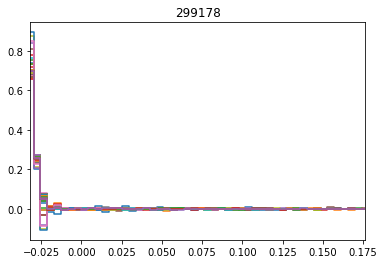

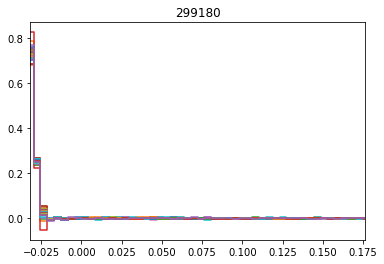

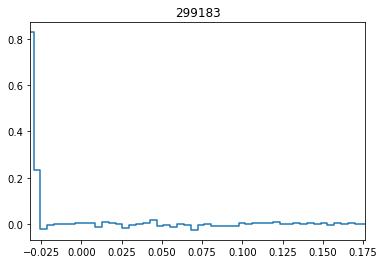

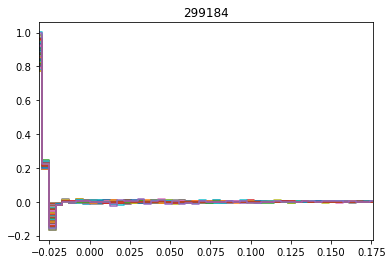

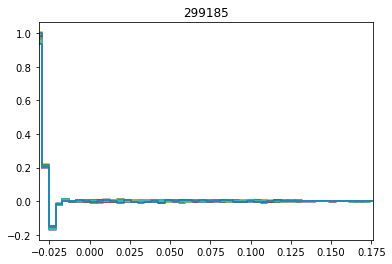

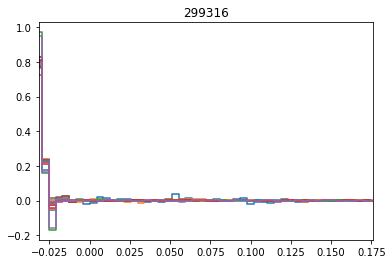

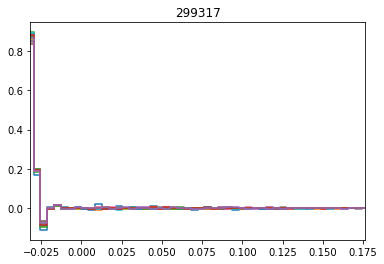

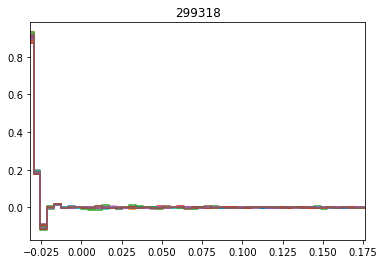

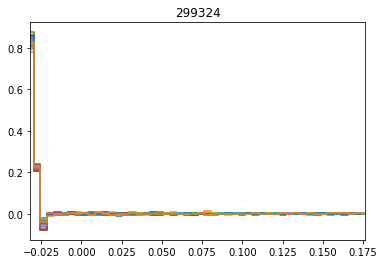

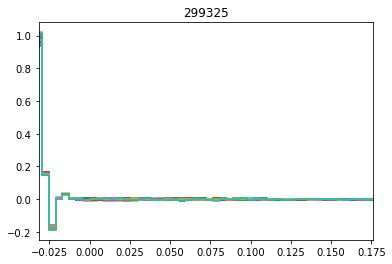

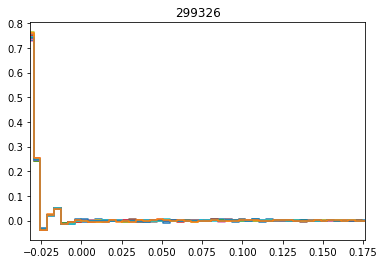

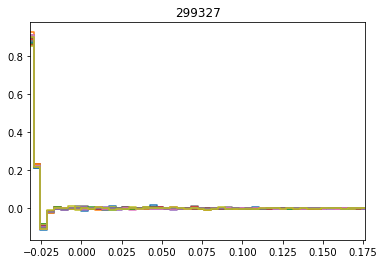

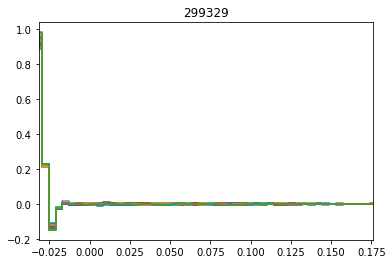

In [230]:
mean_pca_dict = {}
sd_pca_dict = {}
def PlotPCA(run,ls_list,):
    
    fig = plt.figure()
    Xmax=0.1762482476632356
    Xmin=-0.03174947168710477
    Xbins=50

    hname="chargeInner_PXLayer_1"
    global mean_dict
    global sd_dict
    global df_gen_layer1
    

    for ls in ls_list:
        
        ahisto=df_gen_layer1['PC'][run][ls]
        a = len(ahisto)
        if not(a == Xbins):
            ahisto = ahisto[1:-1]
        factor = sum(ahisto)

        x = np.linspace(Xmin,Xmax,Xbins)
        newList = [float(x) / factor for x in ahisto] # normalized histo list dividing ahisto by number of entries
        mean_of_each_LSHisto = np.sum([a*b for a,b in zip(x,ahisto)]) / factor
        mean_pca_dict[ls] = mean_of_each_LSHisto       
        
        plt.xlim(Xmin,Xmax)
        plt.step(x, newList, where='mid',) #normalized histo
        #plt.axvline(mean_of_each_LSHisto-sd_of_each_LSHisto, color='k', linestyle='dashed', linewidth=1)
        #plt.title(run)
        plt.title(run)
        #plt.step(x, ahisto, where='mid',) #non normalized histo
    #plt.legend()
    #plt.annotate("{}".format(np.describe(x)), xy=(0.5, 0.5), xycoords='axes fraction')
    fig.savefig("/eos/home-r/runiyal/SWAN_projects/ML4DC/data_exploration/NEW_PCA_PLOTS/{}.png".format(run))
                
                

#this for loop is for running over all the runs     
#this for loop is for running over all the runs     
for run in run_list:
    PlotPCA(run,run_lumi_dict[run])
                
                

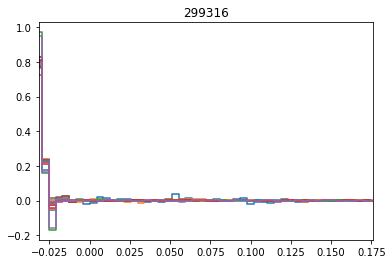

In [228]:
PlotPCA(299316,run_lumi_dict[299316], )

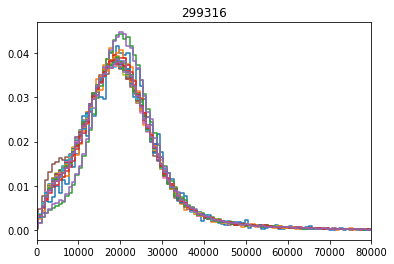

In [202]:
PlotHist(299316,run_lumi_dict[299316], )

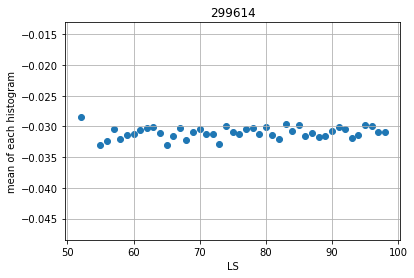

In [203]:
fig, ax = plt.subplots()
plt.xlabel("LS")
plt.ylabel("mean of each histogram")
plt.title("299614")
#plt.xlim(1640,1670,10)#plt.ylim(11000, 12000, 10)
#plt.grid()
#plt.xticks(np.arange(410, 440, step=2))
plt.scatter(mean_pca_dict.keys(), mean_pca_dict.values())
#plt.plot((410, 498), (26000, 26000), 'k-')
ax.grid()

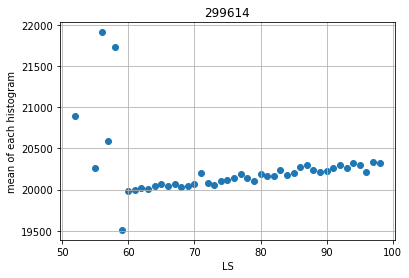

In [204]:
fig, ax = plt.subplots()
plt.xlabel("LS")
plt.ylabel("mean of each histogram")
plt.title("299614")
plt.xlim(1640,1670,10)#plt.ylim(11000, 12000, 10)
#plt.grid()
#plt.xticks(np.arange(410, 440, step=2))
plt.scatter(mean_dict.keys(), mean_dict.values())
#plt.plot((410, 498), (26000, 26000), 'k-')
ax.grid()

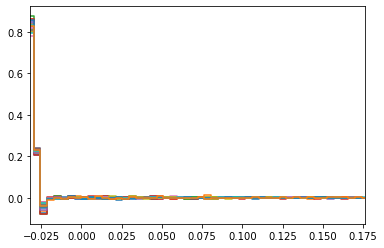

In [209]:
PlotPCA(299324,run_lumi_dict[299324], )

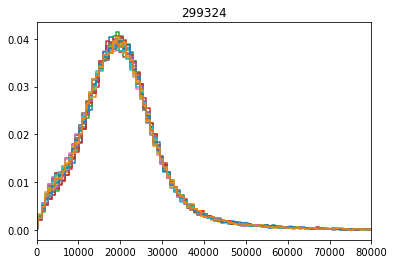

In [210]:
PlotHist(299324,run_lumi_dict[299324], )

# Layer 2

In [4]:
df_gen_layer2= df_gen[df_gen["hname"] == "chargeInner_PXLayer_2"]

In [5]:
%%time
df_gen_layer2.set_index(['fromrun','fromlumi'], inplace=True, drop=False)
df_gen_layer2['histo']=df_gen_layer2['histo'].apply(literal_eval)
df_gen_layer2.sort_index(inplace=True)
#df_charge['labels']=0
df_gen_layer2 = df_gen_layer2[df_gen_layer2["entries"] != 0]
arr_g2 = df_gen_layer2["histo"].values.tolist()
arr_g2 = np.asarray(arr_g2)
arr_g2.shape

/usr/local/bin/start_ipykernel.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/bin/start_ipykernel.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


CPU times: user 7.23 s, sys: 127 ms, total: 7.35 s
Wall time: 7.34 s


In [6]:
%%time
#removing overflow and underflow bins
arr_g2 = np.delete(arr_g2, np.s_[0::101],1)
Sum_gen2 = np.sum(arr_g2, axis = 1)
arr_g2 = arr_g2/np.vstack(Sum_gen2)
#arr_g2 = np.delete(arr_g2, np.s_[0::101],1)
#arr_g3 = np.delete(arr_g3, np.s_[0::101],1)
#arr_g4 = np.delete(arr_g4, np.s_[0::101],1)
# how np.s_ works
#first argument is starting index and last argument is the last argument-1 index, and 1 is the axis for columns

CPU times: user 218 ms, sys: 11.6 ms, total: 229 ms
Wall time: 225 ms


## 1. Generation of PC for different bins of the histograms using Singular Value Decomposition for Layer 2

In [7]:
#genData
from sklearn.decomposition import TruncatedSVD
# define array
G2 = arr_g2
#print(A)
# svd
svd = TruncatedSVD(n_components=25)
svd.fit(G2)
result_gen2 = svd.transform(G2)
print(type(result_gen2))

<class 'numpy.ndarray'>


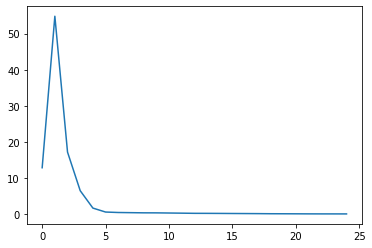

In [8]:
plt.plot(svd.explained_variance_ratio_*100,)

In [9]:
df_gen_layer2["PC"] = result_gen2.tolist()

In [10]:
result_gen2[:,0:1]

array([[0.18052587],
       [0.1810886 ],
       [0.18141632],
       ...,
       [0.1946123 ],
       [0.19372437],
       [0.19422134]])

In [11]:
df_gen_layer2["PC1"] = result_gen2[:,0:1]
df_gen_layer2["PC2"] = result_gen2[:,1:2]
df_gen_layer2["PC3"] = result_gen2[:,2:3]

In [17]:
df_gen_layer2.head()

fromrun  fromlumi                  hname  fromrun.1  \
fromrun fromlumi                                                        
297047  1          297047         1  chargeInner_PXLayer_2     297047   
        2          297047         2  chargeInner_PXLayer_2     297047   
        3          297047         3  chargeInner_PXLayer_2     297047   
        4          297047         4  chargeInner_PXLayer_2     297047   
        5          297047         5  chargeInner_PXLayer_2     297047   

                  fromlumi.1  metype                hname.1  \
fromrun fromlumi                                              
297047  1                  1       3  chargeInner_PXLayer_2   
        2                  2       3  chargeInner_PXLayer_2   
        3                  3       3  chargeInner_PXLayer_2   
        4                  4       3  chargeInner_PXLayer_2   
        5                  5       3  chargeInner_PXLayer_2   

                                                              histo  entries  \
fromrun fromlumi                                                               
297047  1         [0, 0, 28, 88, 108, 121, 157, 161, 163, 129, 1...   102227   
        2         [0, 0, 26, 84, 109, 120, 152, 146, 138, 156, 1...   103446   
        3         [0, 0, 32, 84, 111, 135, 140, 143, 155, 166, 1...   111879   
        4         [0, 1, 32, 98, 160, 184, 193, 174, 178, 160, 1...   128362   
        5         [0, 0, 39, 104, 168, 205, 191, 200, 184, 201, ...   136447   

                     Xmax  Xmin  Xbins  Ymax  Ymin  Ybins  \
fromrun fromlumi                                            
297047  1         80000.0   0.0    100     1     0      1   
        2         80000.0   0.0    100     1     0      1   
        3         80000.0   0.0    100     1     0      1   
        4         80000.0   0.0    100     1     0      1   
        5         80000.0   0.0    100     1     0      1   

                                                                 PC       PC1  \
fromrun fromlumi                                                                
297047  1         [0.18052587279187918, -0.03508188534243764, 0....  0.180526   
        2         [0.18108860460653348, -0.03552478381977468, 0....  0.181089   
        3         [0.18141631767416677, -0.035386615579293075, 0...  0.181416   
        4         [0.18248672931842438, -0.029645634710657006, 0...  0.182487   
        5         [0.18265495542244858, -0.028960256867618196, 0...  0.182655   

                       PC2       PC3  
fromrun fromlumi                      
297047  1        -0.035082  0.005563  
        2        -0.035525  0.005607  
        3        -0.035387  0.005356  
        4        -0.029646  0.002759  
        5        -0.028960  0.002823

In [13]:
df_gen_layer2.fromrun.value_counts()

297219    2637
297178    1378
297101    1102
297411     915
297057     907
297050     776
297503     776
297292     748
297486     623
297487     604
299184     555
297296     491
297675     465
299067     461
299149     439
297488     425
297603     418
297485     415
297604     404
297605     403
297599     402
297505     395
297656     392
297557     381
297100     376
297562     364
299065     330
297722     304
299061     302
299062     296
          ... 
297494      19
297658      18
297501      17
297291      17
297168      17
297284      16
297287      16
297495      16
297282      16
297499      16
297662      16
297663      16
297502      16
297497      16
297048      15
297283      15
297218      15
297049      15
297289      15
297673      15
297288      15
297672      15
297290      15
297498      15
297169      12
297170       7
297598       6
298998       2
299183       1
297678       1
Name: fromrun, Length: 135, dtype: int64

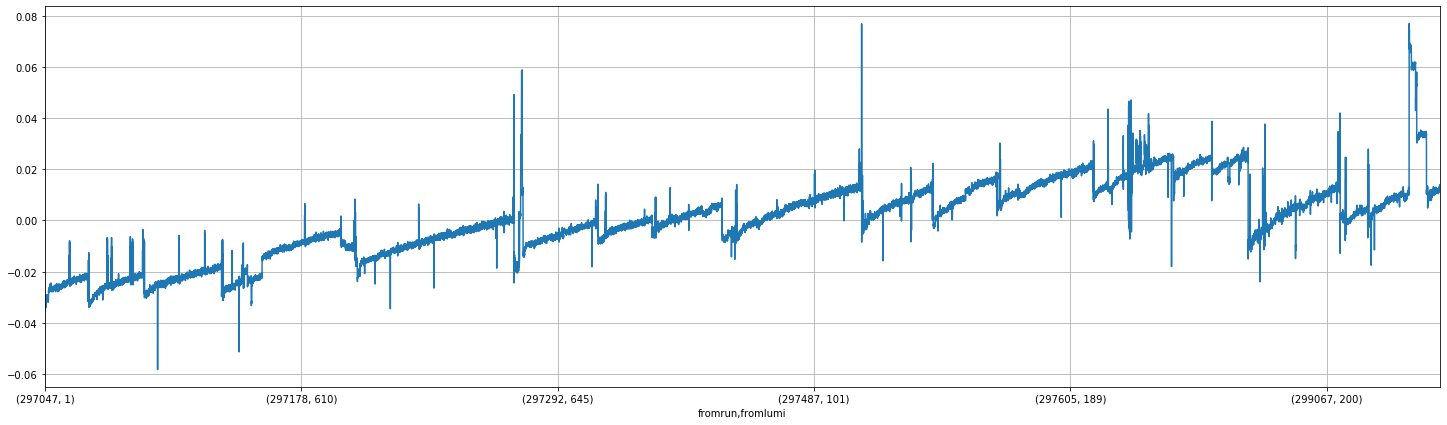

In [19]:
df_gen_layer2["PC2"].plot(figsize = (25,7), grid = True )

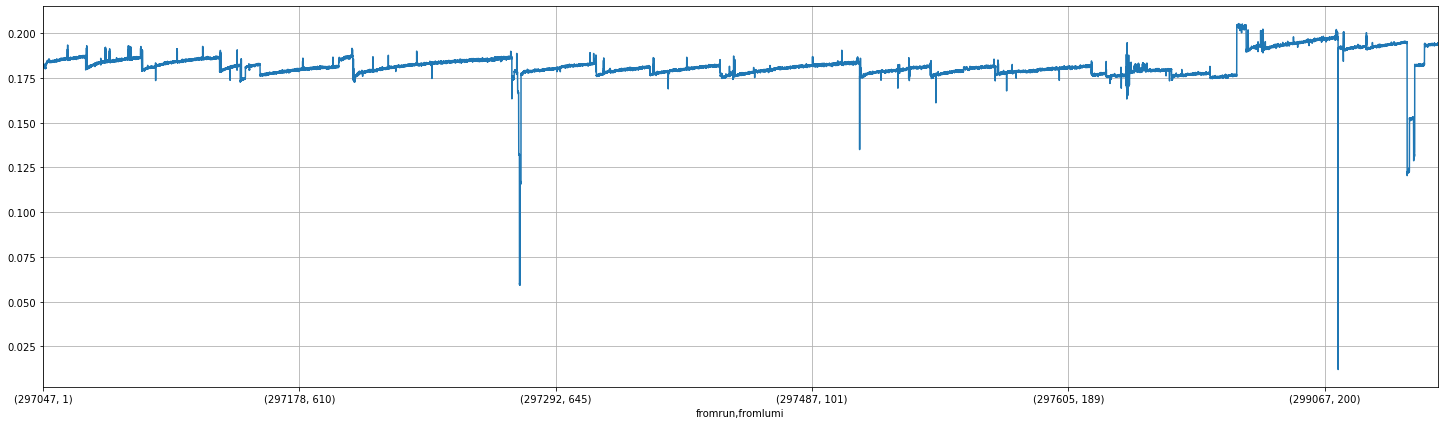

In [20]:
df_gen_layer2["PC1"].plot(figsize = (25,7), grid = True)

In [26]:
df_gen_layer2[df_gen_layer2["PC3"] > 0.0]["fromrun"].unique()
run_list_test = df_gen_layer2[df_gen_layer2["PC3"] > 0.0]["fromrun"].unique().tolist()

In [27]:
run_list_test

[297047,
 297048,
 297049,
 297050,
 297056,
 297057,
 297099,
 297100,
 297101,
 297113,
 297114,
 297168,
 297169,
 297170,
 297171,
 297175,
 297176,
 297177,
 297178,
 297211,
 297215,
 297218,
 297219,
 297224,
 297227,
 297281,
 297282,
 297283,
 297284,
 297285,
 297286,
 297287,
 297288,
 297289,
 297290,
 297291,
 297292,
 297293,
 297296,
 297308,
 297359,
 297411,
 297424,
 297425,
 297426,
 297429,
 297430,
 297431,
 297432,
 297433,
 297434,
 297435,
 297467,
 297468,
 297469,
 297474,
 297483,
 297484,
 297485,
 297486,
 297487,
 297488,
 297494,
 297495,
 297496,
 297497,
 297498,
 297499,
 297501,
 297502,
 297503,
 297504,
 297505,
 297557,
 297558,
 297562,
 297563,
 297598,
 297599,
 297603,
 297604,
 297605,
 297620,
 297656,
 297657,
 297658,
 297659,
 297660,
 297661,
 297662,
 297663,
 297664,
 297665,
 297666,
 297670,
 297671,
 297672,
 297673,
 297674,
 297675,
 297678,
 297722,
 297723,
 299067,
 299316,
 299317,
 299318,
 299324]

<Figure size 432x288 with 0 Axes>

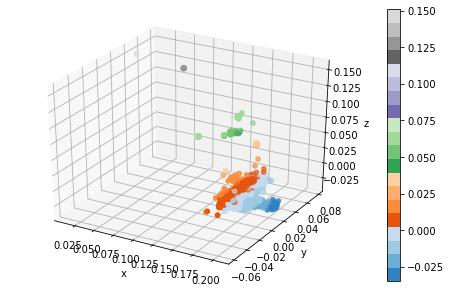

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = df_gen_layer2["PC1"]
y = df_gen_layer2["PC2"]
z = df_gen_layer2["PC3"]

#z = (z-np.nanmin(z)) /(np.nanmax(z) - np.nanmin(z))

fig = plt.figure()
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
#fig = plt.figure(figsize=(8,5))
#ax11=fig1.add_subplot(211,projection='3d')
ax.scatter(x,y,z,cmap='tab20c',c=z)
p = ax.scatter(x,y,z,cmap='tab20c',c=z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.colorbar(p)
plt.show()

In [ ]:
# from sklearn.cluster import DBSCAN
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# X = StandardScaler().fit_transform(result_gen2[:,0:2])

# clustering = DBSCAN(eps=100, min_samples=5).fit(X)
# uniqueValues, occurCount = np.unique(clustering.labels_, return_counts=True)
# clusters = clustering.labels_

In [52]:

# colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
# vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

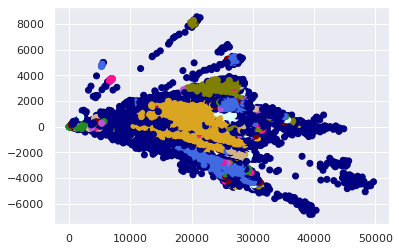

In [50]:
# plt.scatter(X[:,0], X[:,1], c=vectorizer(clusters))

In [22]:


# from sklearn.neighbors import NearestNeighbors

# from matplotlib import pyplot as plt
# import seaborn as sns
# sns.set()

In [23]:
# result_gen2[:,0:2]

array([[ 0.18052587, -0.03508189],
       [ 0.1810886 , -0.03552478],
       [ 0.18141632, -0.03538662],
       ...,
       [ 0.1946123 ,  0.01255962],
       [ 0.19372437,  0.01110394],
       [ 0.19422134,  0.01256831]])

In [28]:
# neigh = NearestNeighbors(n_neighbors=100)
# nbrs = neigh.fit(result_gen2[:,0:2])
# distances, indices = nbrs.kneighbors(result_gen2[:,0:2])

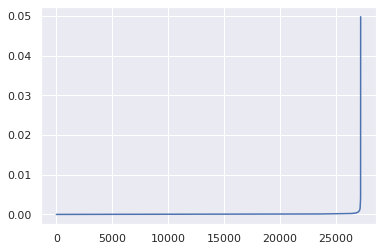

In [29]:
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]
# plt.plot(distances)

# Plotting function for both PCA and regular bins

In [42]:
run_list = [i for i in df_gen_layer2.fromrun.unique()]
run_lumi_dict = {}
for run in run_list:
    run_lumi_dict[run] = df_gen_layer2[df_gen_layer2["fromrun"] == run]["fromlumi.1"].values.tolist()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/usr/local/bin/start_ipykernel.py:13: RuntimeWarning: More t

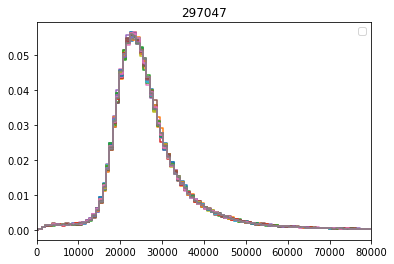

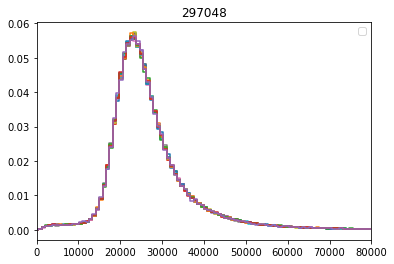

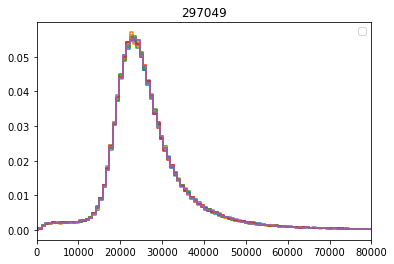

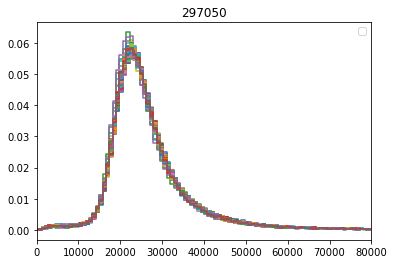

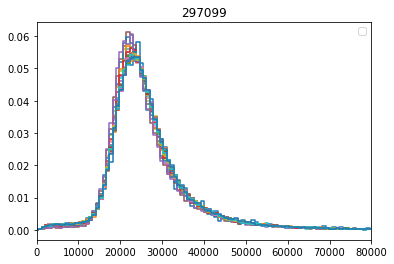

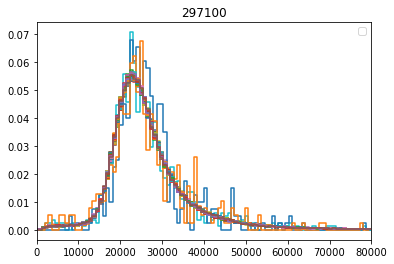

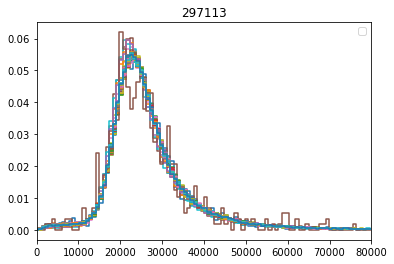

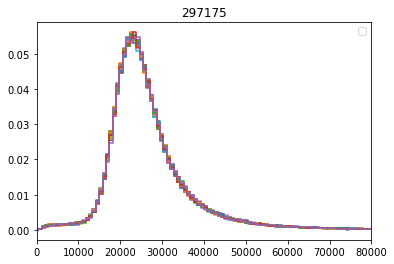

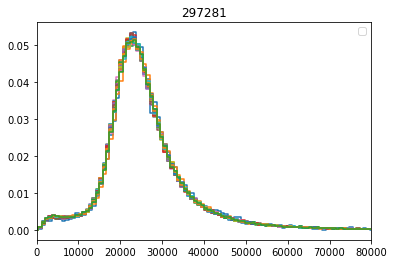

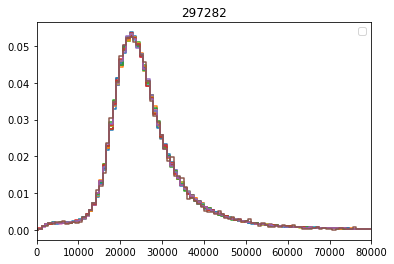

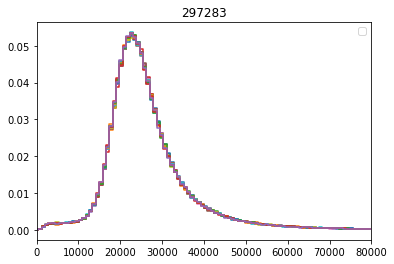

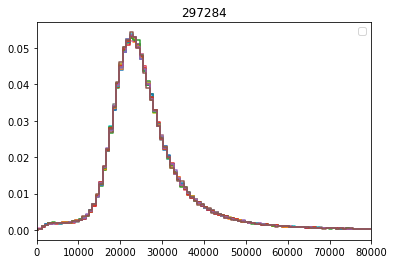

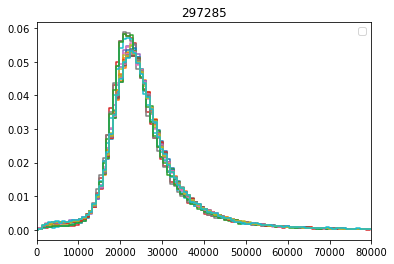

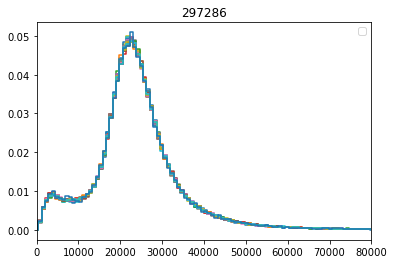

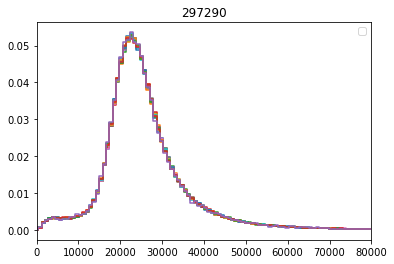

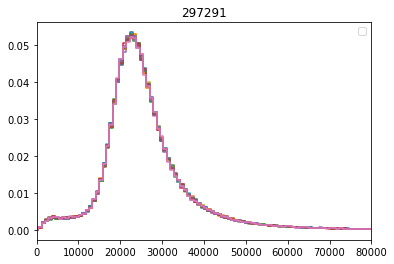

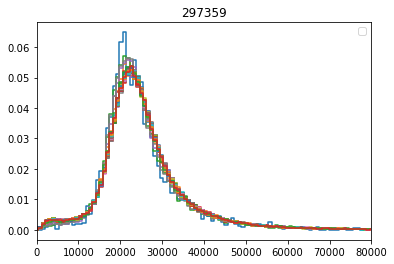

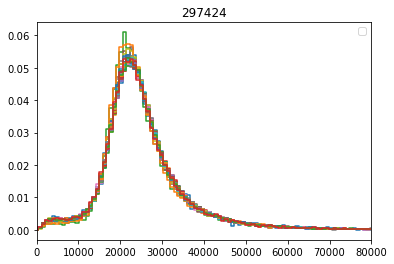

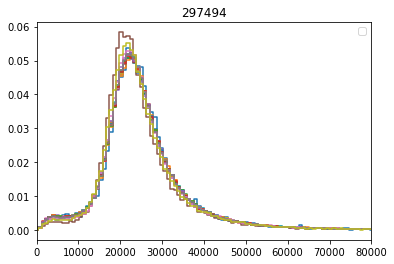

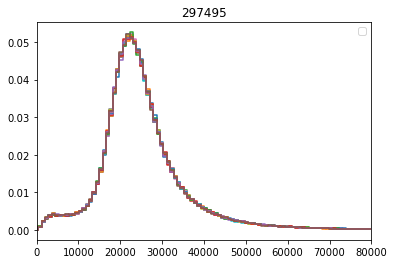

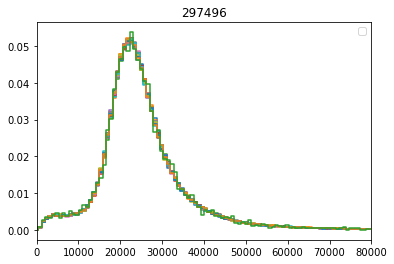

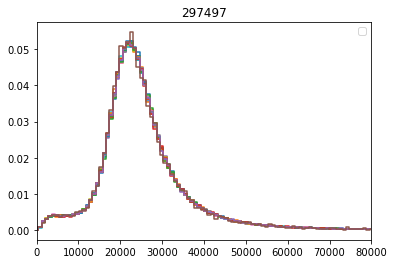

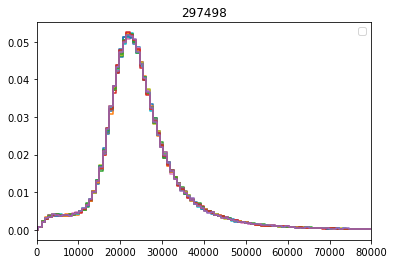

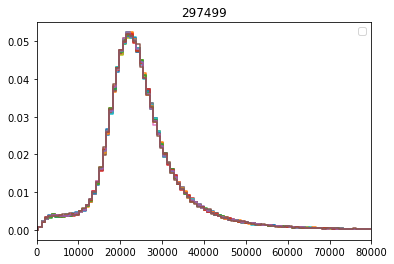

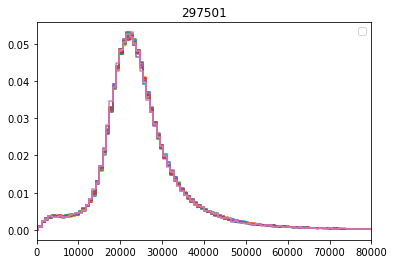

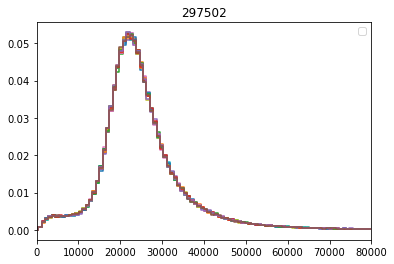

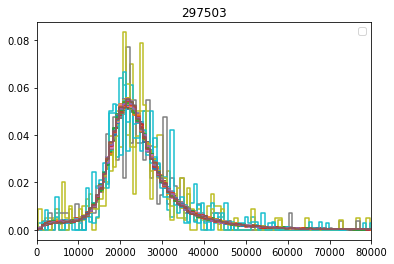

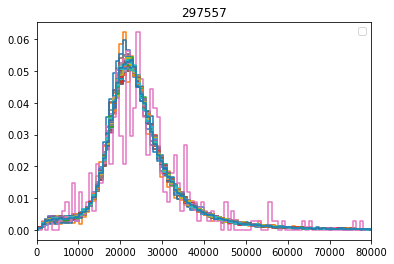

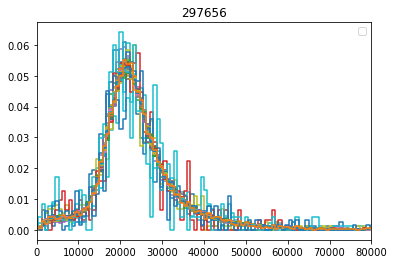

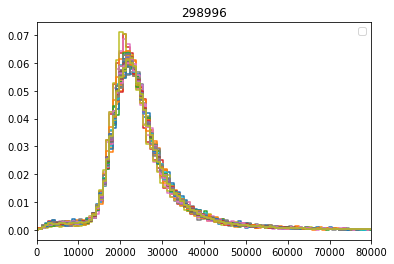

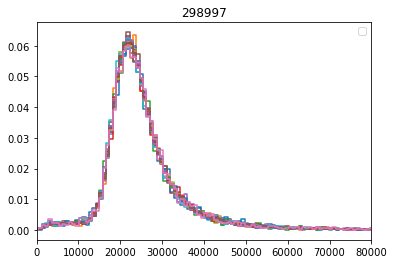

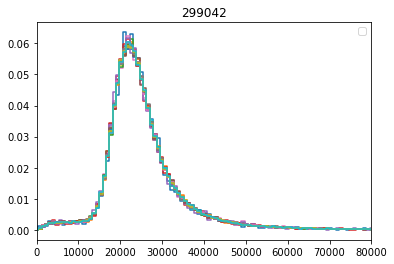

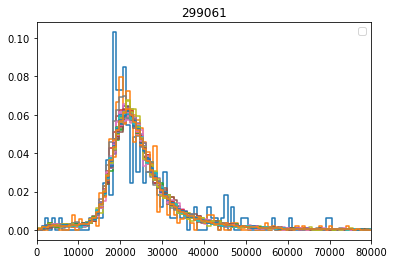

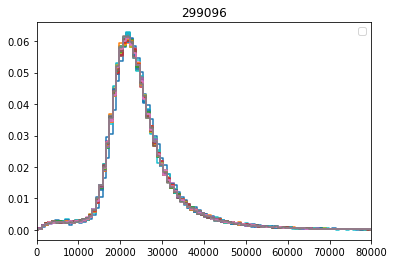

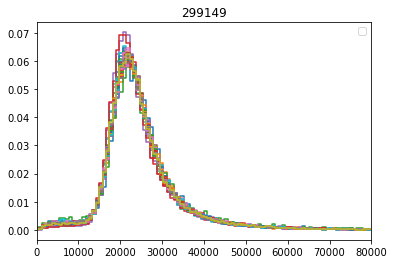

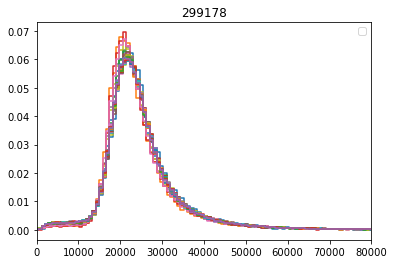

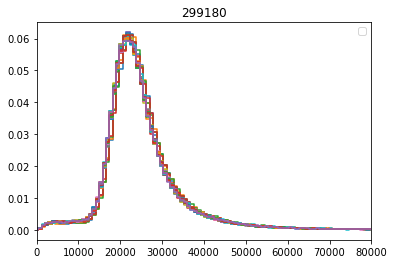

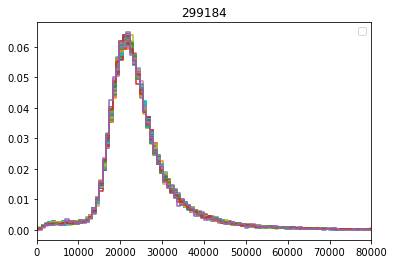

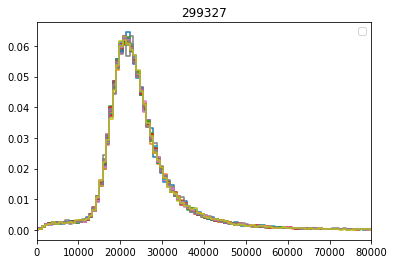

In [67]:
#plot hist
mean_dict = {}
sd_dict = {}
def PlotHist(run,ls_list, ):
    '''
    this function takes the run number and the list of lumiSections
    associated with that run. It further uses that info to extract histogram entries asssociated with each
    LS and plots them on a single histogram
    Overall you'd get a histogram with all lumisection plotted for that particular run
    '''
    
    #declaration for hist
    fig = plt.figure()
    Xmax=80000.0
    Xmin=0.0
    Xbins=100

    hname="chargeInner_PXLayer_2"
    global mean_dict
    global sd_dict
    
    global df_gen_layer2
    for ls in ls_list:
        
        ahisto=df_gen_layer2['histo'][run][ls]
        a = len(ahisto)
        if not(a == Xbins):
            ahisto = ahisto[1:-1]
        factor = sum(ahisto)
        x = np.linspace(Xmin,Xmax,Xbins)
        newList = [float(x) / factor for x in ahisto] # normalized histo list dividing ahisto by number of entries
        
        mean_of_each_LSHisto = np.sum([a*b for a,b in zip(x,ahisto)]) / factor
        mean_dict[ls] = mean_of_each_LSHisto
        plt.xlim(Xmin,Xmax)
        plt.step(x, newList, where='mid',) #normalized histo
        #plt.axvline(mean_of_each_LSHisto-sd_of_each_LSHisto, color='k', linestyle='dashed', linewidth=1)
        plt.title(run,)
        #plt.step(x, ahisto, where='mid',) #non normalized histo
    plt.legend()
    #plt.annotate("{}".format(np.describe(x)), xy=(0.5, 0.5), xycoords='axes fraction')
    #fig.savefig("/eos/home-r/runiyal/SWAN_projects/ML4DC/data_exploration/NEW_HIST_PLOTS_L2/{}.png".format(run))
    
    #del fig
    
    
#this for loop is for running over all the runs     
for run in run_list_test:
    PlotHist(run,run_lumi_dict[run])
#PlotHist(297281,run_lumi_dict[297281])

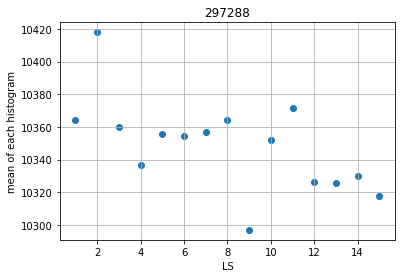

In [270]:
fig, ax = plt.subplots()
plt.xlabel("LS")
plt.ylabel("mean of each histogram")
plt.title("297288")
#plt.xlim(1640,1670,10)#plt.ylim(11000, 12000, 10)
#plt.grid()
#plt.xticks(np.arange(410, 440, step=2))
plt.scatter(mean_dict.keys(), mean_dict.values())
#plt.plot((410, 498), (26000, 26000), 'k-')
ax.grid()

In [263]:
min(min(df_gen_layer2["PC"])), max(max(df_gen_layer2["PC"]))

(-3.850907394965556, 49713.89342216439)

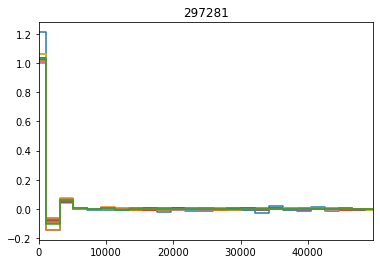

In [46]:
mean_pca_dict = {}
sd_pca_dict = {}
def PlotPCA(run,ls_list,):
    
    fig = plt.figure()
    Xmax=49713.89342216441
    Xmin=-3.8564050990569223
    Xbins=25

    hname="chargeInner_PXLayer_2"
    global mean_dict
    global sd_dict
    global df_gen_layer2
    

    for ls in ls_list:
        
        ahisto=df_gen_layer2['PC'][run][ls]
        a = len(ahisto)
        if not(a == Xbins):
            ahisto = ahisto[1:-1]
        factor = sum(ahisto)

        x = np.linspace(Xmin,Xmax,Xbins)
        newList = [float(x) / factor for x in ahisto] # normalized histo list dividing ahisto by number of entries
        mean_of_each_LSHisto = np.sum([a*b for a,b in zip(x,ahisto)]) / factor
        mean_pca_dict[ls] = mean_of_each_LSHisto       
        
        #https://math.stackexchange.com/questions/857566/how-to-get-the-standard-deviation-of-a-given-histogram-image
        sd_of_each_LSHisto = np.sqrt(np.sum(np.square([i - mean_of_each_LSHisto for i in x])) / factor)
        sd_pca_dict[ls] = sd_of_each_LSHisto
        plt.xlim(Xmin,Xmax)
        plt.step(x, newList, where='mid',) #normalized histo
        #plt.axvline(mean_of_each_LSHisto-sd_of_each_LSHisto, color='k', linestyle='dashed', linewidth=1)
        #plt.title(run)
        plt.title(run)
        #plt.step(x, ahisto, where='mid',) #non normalized histo
    #plt.legend()
    #plt.annotate("{}".format(np.describe(x)), xy=(0.5, 0.5), xycoords='axes fraction')
    fig.savefig("/eos/home-r/runiyal/SWAN_projects/ML4DC/data_exploration/NEW_PCA_PLOTS_L2/{}.png".format(run))
                
                

#this for loop is for running over all the runs     
#this for loop is for running over all the runs     
# for run in run_list:
#     PlotPCA(run,run_lumi_dict[run])
                
PlotPCA(297281,run_lumi_dict[297281])               

In [290]:
sd_pca_dict

{1: 731.4023627992242,
 2: 667.0763318283704,
 3: 666.2297541943617,
 4: 855.727006577246,
 5: 649.6927246254248,
 6: 670.4226786392908,
 7: 657.4024001176083,
 8: 656.0792943894254,
 9: 666.4159171635151,
 10: 672.9862047167904,
 11: 662.4871857840253,
 12: 668.0549902805245,
 13: 655.4380452328708,
 14: 661.726487748288,
 15: 817.5629710340612}

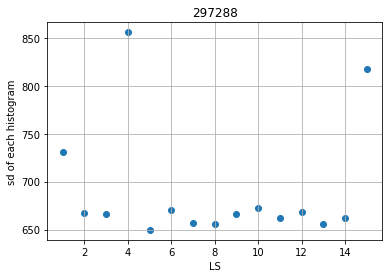

In [292]:
fig, ax = plt.subplots()
plt.xlabel("LS")
plt.ylabel("sd of each histogram")
plt.title("297288")
#plt.xlim(1640,1670,10)#plt.ylim(11000, 12000, 10)
#plt.grid()
#plt.xticks(np.arange(410, 440, step=2))
plt.scatter(sd_pca_dict.keys(), sd_pca_dict.values())
#plt.plot((410, 498), (26000, 26000), 'k-')
ax.grid()

# Auto Encoder

In [46]:
from keras.layers import Input, Dense
from keras.models import Model

input_hist = Input(shape=(50,))
# "encoded" is the encoded representation of the input
encoded = Dense(10, activation='relu')(input_hist)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(50, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_hist, decoded)

W0424 18:26:52.464784 139688047490880 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [47]:
# this model maps an input to its encoded representation
encoder = Model(input_hist, encoded)

In [48]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(10,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [49]:
from sklearn.model_selection import train_test_split 